# Baseball Statistics

Baseball is a game full of statistics, and most of those statistics have been consistently and carefully tracked going back to the late 1800s. That makes professional baseball a playground for data analysts. Here I look at interesting correlations between players, their stats, and their salaries.

**Data Source:** [Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/). The data set I used was through the 2018 season.

Copyright © 2019 Ken Norton (ken@kennethnorton.com)

In [1]:
import sys
import logging
import datetime as dt

import numpy as np
import scipy as sp
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
# Set default matplotlib settings
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16

In [3]:
# Get the data
pitching = pd.read_csv('data/Pitching.csv')
salaries = pd.read_csv('data/Salaries.csv')
people = pd.read_csv('data/People.csv')
fielding = pd.read_csv('data/Fielding.csv')
teams = pd.read_csv('data/Teams.csv')
hof = pd.read_csv('data/HallofFame.csv')
batting = pd.read_csv('data/Batting.csv')

In [4]:
# A quick function for looking at the correlation between two values
def correlation(x, y):
    std_x = (x - x.mean()) / x.std(ddof=0)
    std_y = (y - y.mean()) / y.std(ddof=0)
    
    return (std_x * std_y).mean()

## Pitching

Let's begin by looking at data for pitchers. The set contains data 9,655 players for 148 seasons, a total of 46,699 individual player seasons.

Here's the key to the individual columns:
```
playerID       Player ID code
yearID         Year
stint          player's stint (order of appearances within a season)
teamID         Team
lgID           League
W              Wins
L              Losses
G              Games
GS             Games Started
CG             Complete Games 
SHO            Shutouts
SV             Saves
IPOuts         Outs Pitched (innings pitched x 3)
H              Hits
ER             Earned Runs
HR             Homeruns
BB             Walks
SO             Strikeouts
BAOpp          Opponent's Batting Average
ERA            Earned Run Average
IBB            Intentional Walks
WP             Wild Pitches
HBP            Batters Hit By Pitch
BK             Balks
BFP            Batters faced by Pitcher
GF             Games Finished
R              Runs Allowed
SH             Sacrifices by opposing batters
SF             Sacrifice flies by opposing batters
GIDP           Grounded into double plays by opposing batter
```

In [5]:
pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,0,0,78,43,23,0,11,1,NaN,7.96,NaN,7,NaN,0,146.0,0,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,0,0,792,361,132,4,37,13,NaN,4.50,NaN,7,NaN,0,1291.0,0,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,0,0,3,8,3,0,0,0,NaN,27.00,NaN,2,NaN,0,14.0,0,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,1,0,639,295,103,3,31,15,NaN,4.35,NaN,20,NaN,0,1080.0,1,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,0,0,27,20,10,0,3,0,NaN,10.00,NaN,0,NaN,0,57.0,0,21,NaN,NaN,NaN


In [6]:
pitching.describe()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
count,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,42259.000000,46607.000000,32121.000000,46699.000000,45965.000000,46699.000000,46696.000000,46699.000000,46699.000000,27512.000000,27512.000000,26381.000000
mean,1970.476498,1.080901,4.644468,4.644468,23.695861,9.341827,3.036403,0.432921,1.501167,250.026617,83.545301,35.632048,6.445256,29.471980,46.524722,0.314151,5.099874,2.340649,2.616330,2.384140,0.298636,356.709247,6.301827,42.376111,2.791582,2.216996,5.946211
std,38.009031,0.287667,5.760254,4.950416,18.557884,12.221776,6.974422,1.092617,5.003730,255.016879,83.837896,33.187179,7.001005,27.942752,49.385648,0.625269,5.406189,2.734361,3.699836,3.164046,0.748765,357.066334,9.947505,42.854273,3.279006,2.372667,6.370744
min,1871.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1943.000000,1.000000,0.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,49.000000,18.000000,9.000000,1.000000,7.000000,8.000000,0.240000,3.150000,0.000000,0.000000,0.000000,0.000000,74.000000,0.000000,10.000000,0.000000,0.000000,1.000000
50%,1980.000000,1.000000,2.000000,3.000000,21.000000,2.000000,0.000000,0.000000,0.000000,163.000000,54.000000,24.000000,4.000000,21.000000,31.000000,0.266000,4.150000,1.000000,2.000000,1.000000,0.000000,237.000000,3.000000,27.000000,2.000000,1.000000,4.000000
75%,2003.000000,1.000000,7.000000,7.000000,35.000000,17.000000,2.000000,0.000000,1.000000,386.000000,131.000000,57.000000,9.000000,44.000000,68.000000,0.300000,5.520000,4.000000,4.000000,3.000000,0.000000,553.000000,8.000000,66.000000,4.000000,3.000000,9.000000
max,2018.000000,5.000000,60.000000,48.000000,106.000000,75.000000,75.000000,16.000000,62.000000,2040.000000,772.000000,291.000000,50.000000,289.000000,513.000000,9.990000,189.000000,23.000000,83.000000,54.000000,16.000000,2906.000000,84.000000,519.000000,27.000000,17.000000,47.000000


In [7]:
pitching.nunique()

playerID    9655
yearID       148
stint          5
teamID       149
lgID           6
W             54
L             43
G             94
GS            75
CG            74
SHO           15
SV            57
IPouts      1311
H            534
ER           216
HR            48
BB           209
SO           338
BAOpp        446
ERA         1167
IBB           22
WP            61
HBP           42
BK            16
BFP         1736
GF            78
R            345
SH            25
SF            18
GIDP          44
dtype: int64

## Relationship between pitching statistics

I begin by exploring the relationship between certain pitching stats.

### Outs Pitched (Innings Pitched x 3) vs. Wins

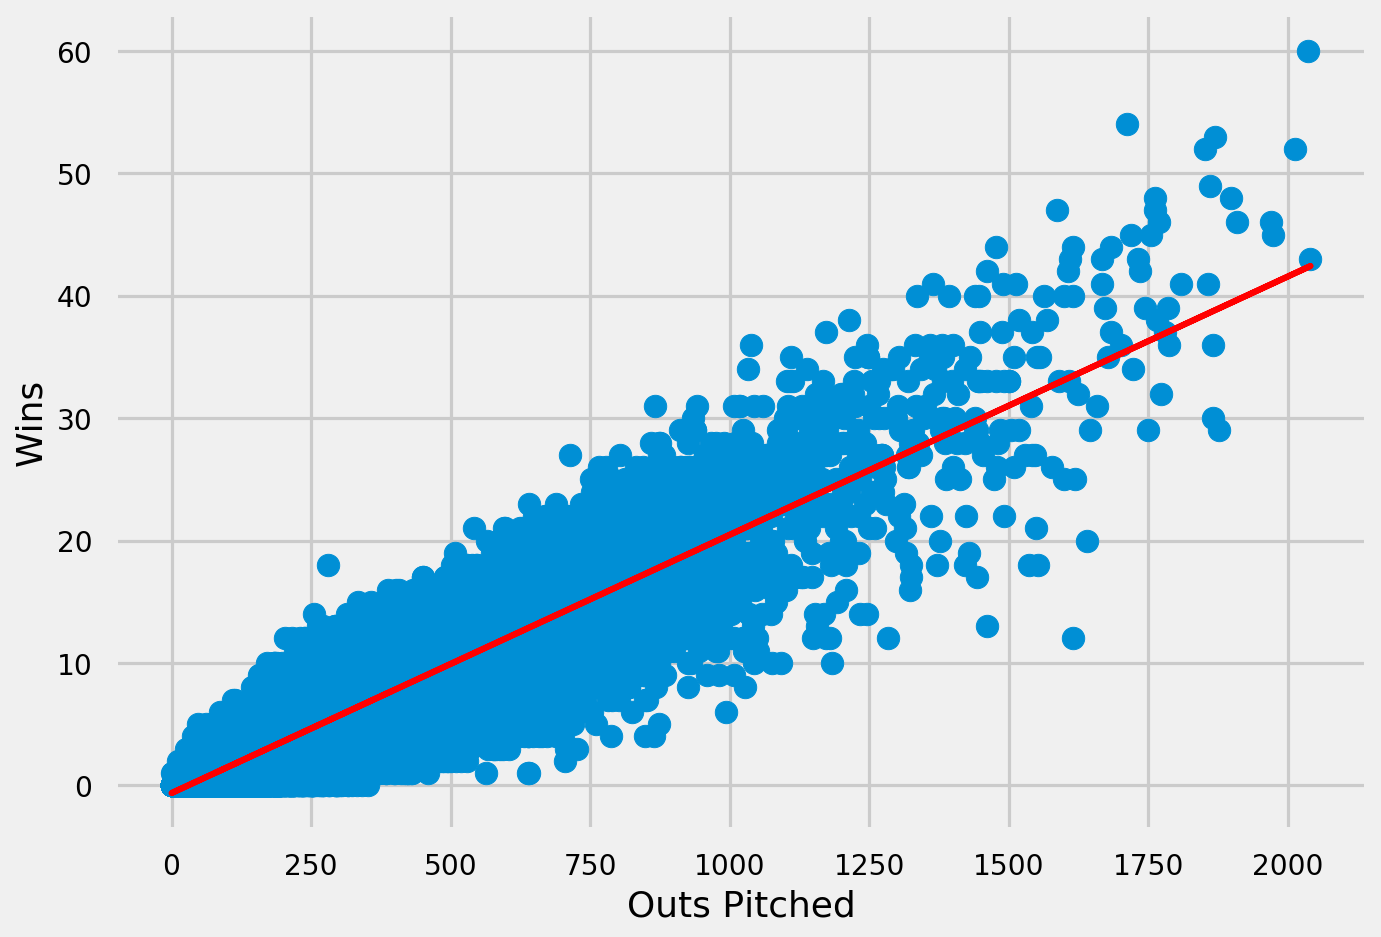

In [8]:
plt.xlabel('Outs Pitched')
plt.ylabel('Wins')
x = pitching['IPouts']
y = pitching['W']
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

In [9]:
correlation(pitching['IPouts'], pitching['W'])

0.9345152011889937

Unsurprisingly, there's a very strong correlation between outs pitched and wins - for one thing, a pitcher must pitch at least 5 innings to record a win.

### Games Started vs. Wins

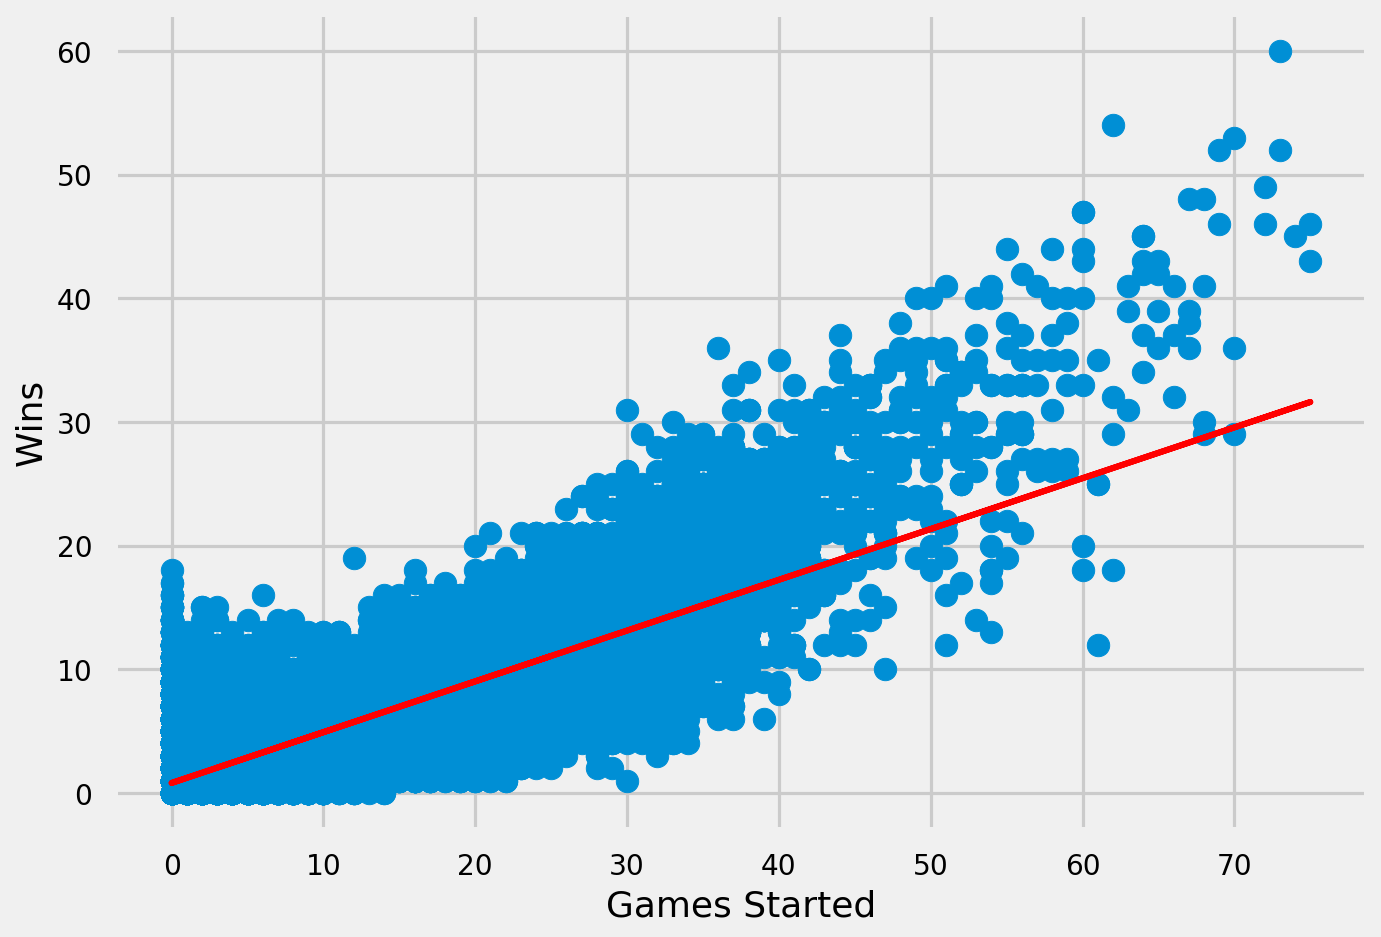

In [10]:
plt.xlabel('Games Started')
plt.ylabel('Wins')
x = pitching['GS']
y = pitching['W']
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

Also not terribly surprising: starting pitchers are more likely to record wins in baseball.

### Wins vs. Strikeouts

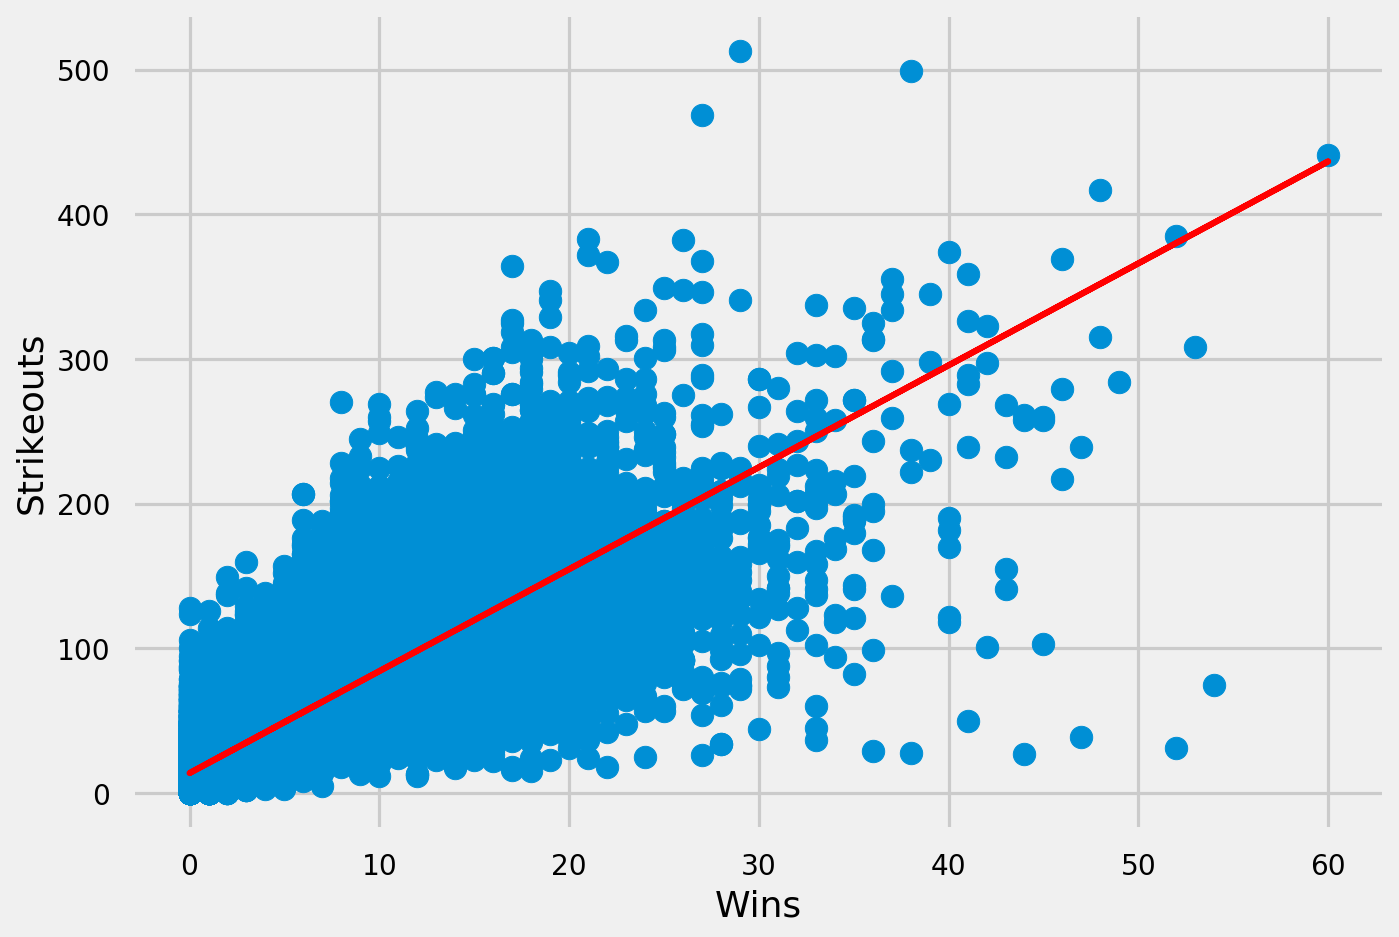

In [11]:
plt.xlabel('Wins')
plt.ylabel('Strikeouts')
x = pitching['W']
y = pitching['SO']
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

In [12]:
correlation(pitching['W'], pitching['SO'])

0.821822997935493

Outs pitched, wins, and games started are all statistics that have a direct relationship, so let's look a bit deeper. Wins and strikeouts aren't derived from each other, but you'd expect there to be a strong correlation, and in fact there is.

## Statistics that change over time

What about statistics that have changed markedly over the years? The game of baseball has changed significantly since the late 1800s:
* Equipment - cleats, bats, and even the ball itself have changed many times over the years
* Player fitness - our understanding of nutrition, physical fitness, and training regiments have evolved (as one example, how many players were smoking in the dugouts in 2018 vs. 1908?)
* Rules - the rules have changed
* Coaching strategies - the modern pitching rotation, pitch count limits, and roster sizes have all led to changes in the game

### Games started over the years

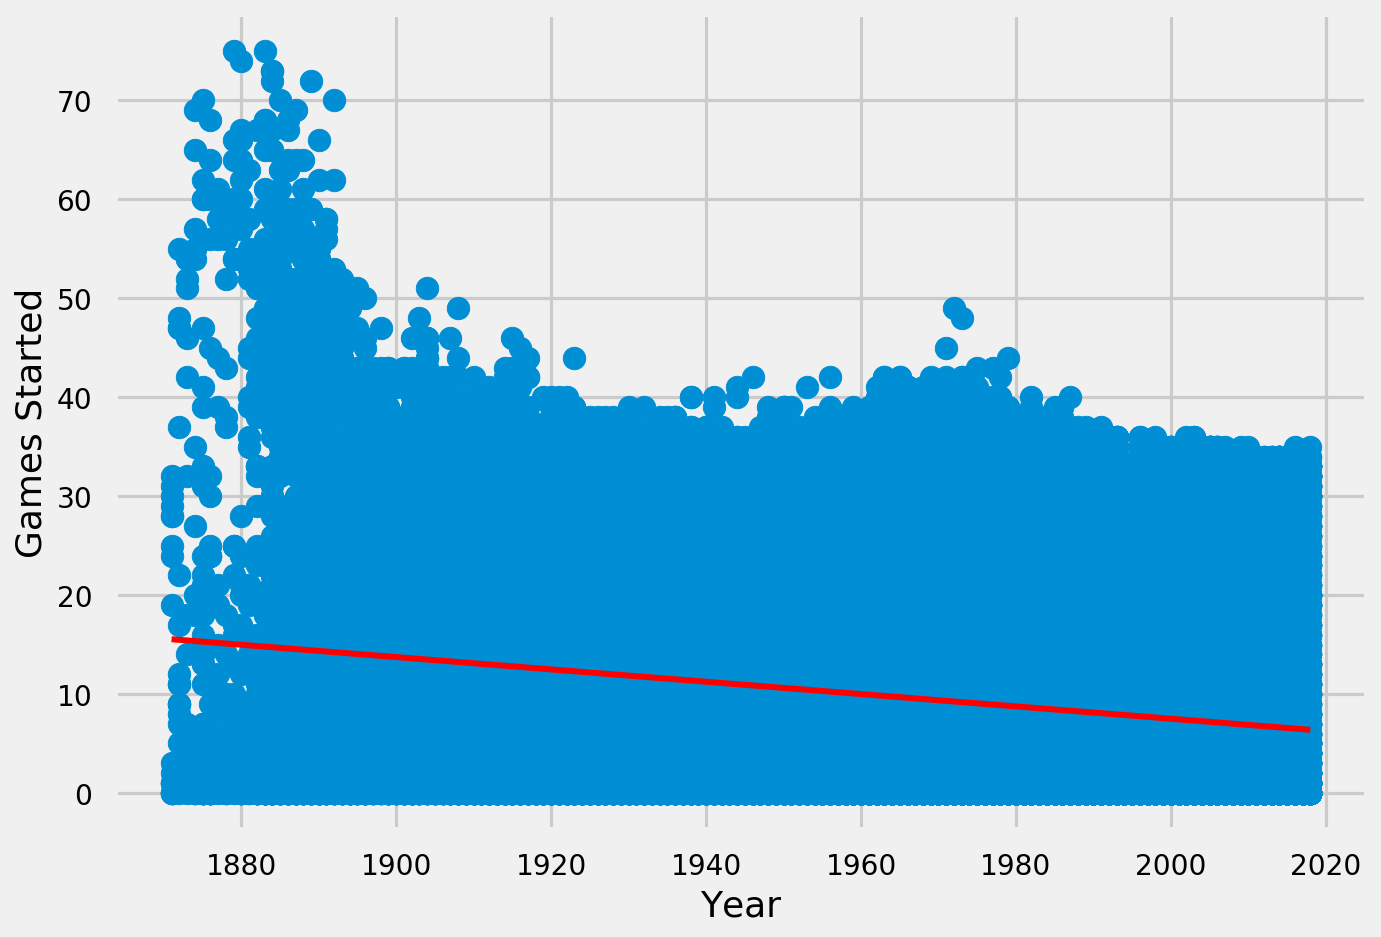

In [13]:
plt.xlabel('Year')
plt.ylabel('Games Started')
x = pitching['yearID']
y = pitching['GS']
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

No pitcher has started more than 40 games since the early 1980s, well below the 70+ games started in the 1800s. The modern four-man pitching rotation and larger rosters are responsible for this.

### Complete games over the years

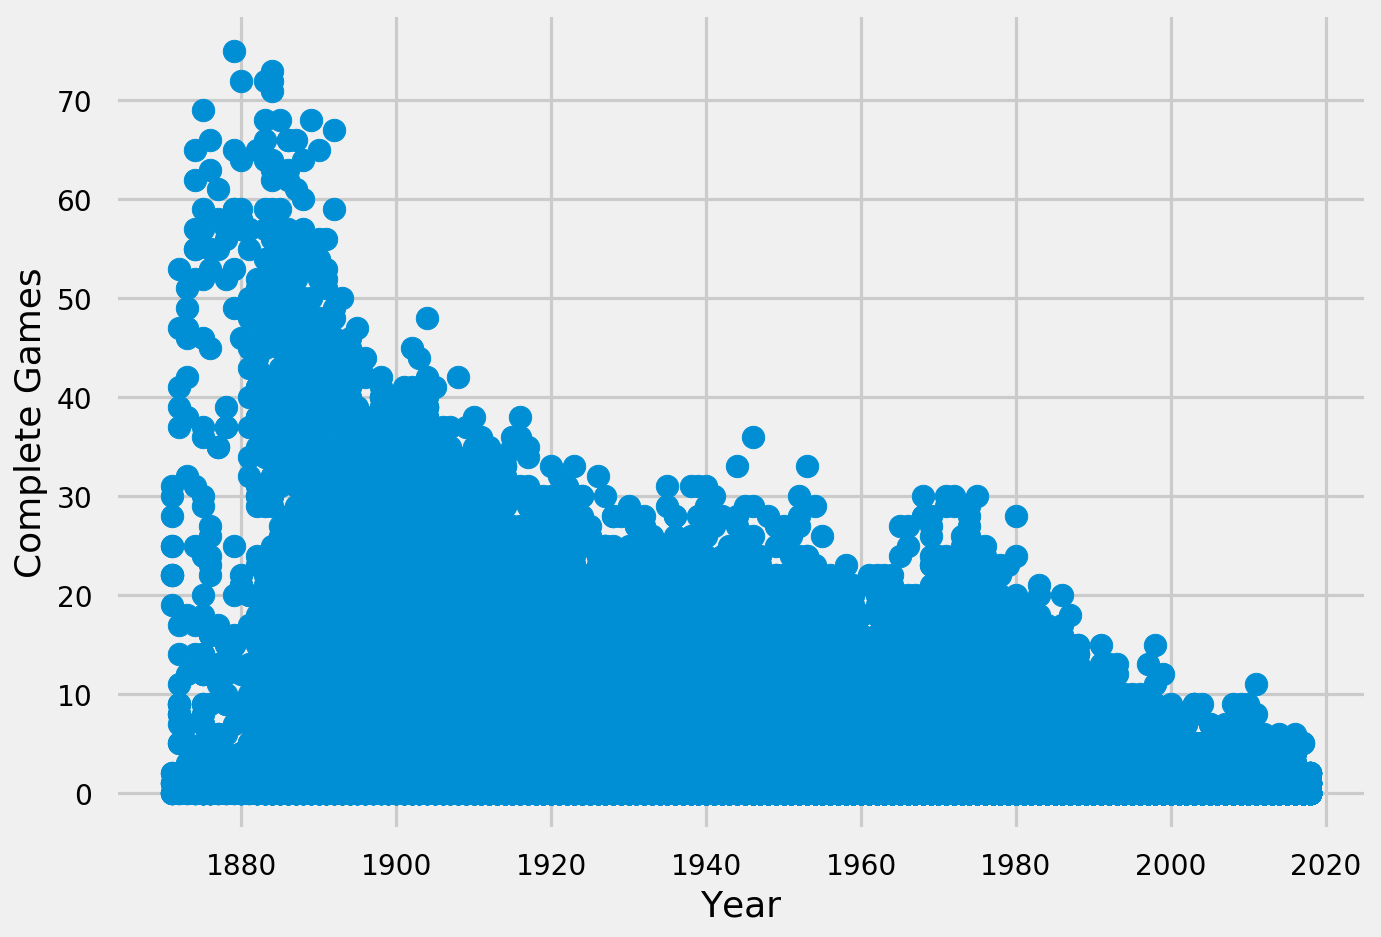

In [14]:
plt.xlabel('Year')
plt.ylabel('Complete Games')
x = pitching['yearID']
y = pitching['CG']
plt.scatter(x, y)

Naturally, fewer starts means fewer complete games, but the decline here is even more significant, likely due to increased utilization of bullpen relievers and the more recent concern about pitch counts. There's a marked decline even since 1980 in the number of complete games pitched, and nobody has pitched more then 10 in a decade.

### Saves over the years

The Save is a more recent creation. In MLB a save goes to the relief pitcher if:

* He is the finishing pitcher in a game won by his team;
* He is not the winning pitcher;
* He is credited with at least ⅓ of an inning pitched; and
* He satisfies one of the following conditions:
  * He enters the game with a lead of no more than three runs and pitches for at least one inning
  * He enters the game, regardless of the count, with the potential tying run either on base, at bat or on deck
  * He pitches for at least three innings.

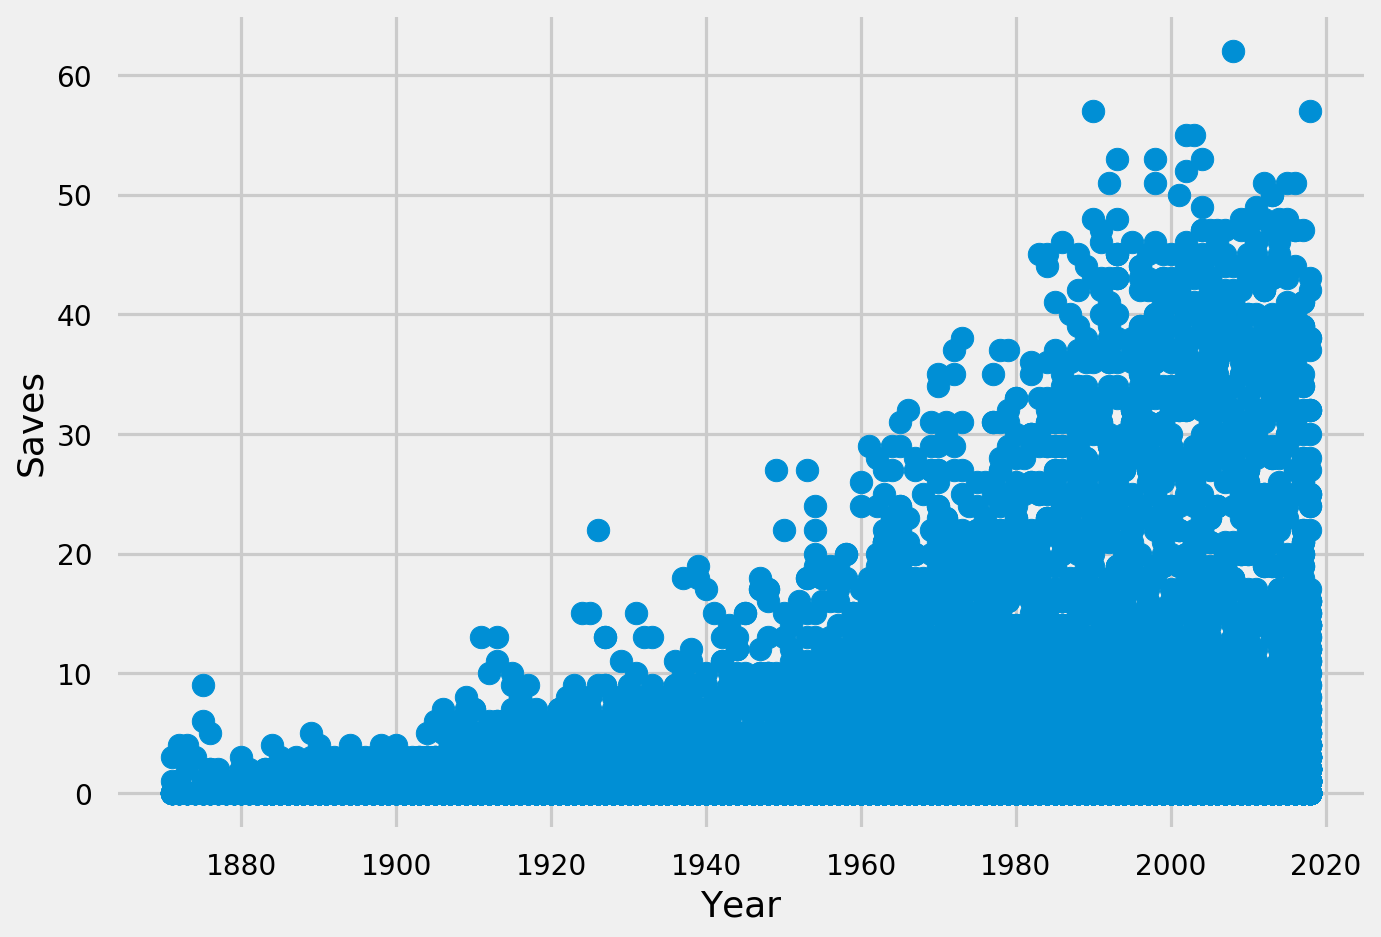

In [15]:
plt.xlabel('Year')
plt.ylabel('Saves')
x = pitching['yearID']
y = pitching['SV']
plt.scatter(x, y)

I was suprised to see that Saves go back to the 1800s since it is pretty much a modern creation. It looks Lahman's has retroactively generated save statistics, which is fascinating. Not surprisingly, relief pitchers and especially closers are a modern phenomenon, so the number of saves per pitcher has increased over the years, especially over the last 35 years as the Save has become an integral aspect of the game.

### Hit by pitch ("plunking") over the years

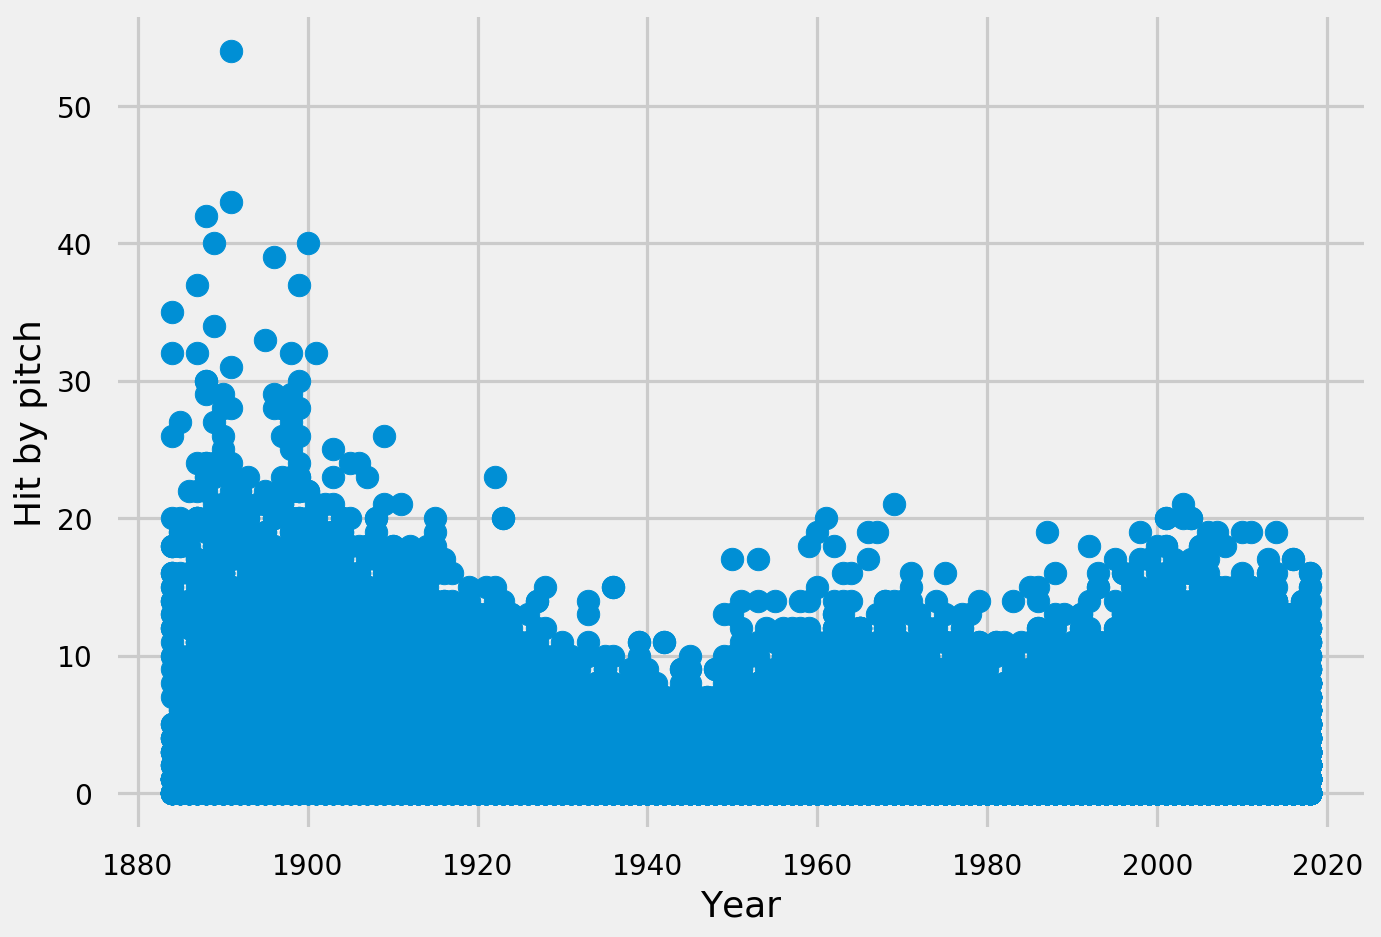

In [16]:
plt.xlabel('Year')
plt.ylabel('Hit by pitch')
x = pitching['yearID']
y = pitching['HBP']
plt.scatter(x, y)

When a pitcher hits (or "plunks") a batter with the ball, the batter takes first base just as if he'd walked. The pitcher is penalized with an HBP (hit by pitch) and the runner is earned. I was curious to see how HBP had changed over the years. 

When you first glance at this scatterplot, you might assume pitchers hit fewer batters today than they did at the turn of the 20th century. However, remember that pitchers in the 1800s pitched more games and faced more batters than they do in the modern era. To really get a sense of HBP trends we need to normalize it by the number of batters faced.

When looking at ratios, it's a good idea to filter out outliers who have a small sample size. For example, if a pitcher only faced 2 batters in a season and hit one of them, we don't want his 0.5 in our analysis since most pitchers faced hundreds of batters in a season. So let's only look at pitchers who faced at least 100 that season.

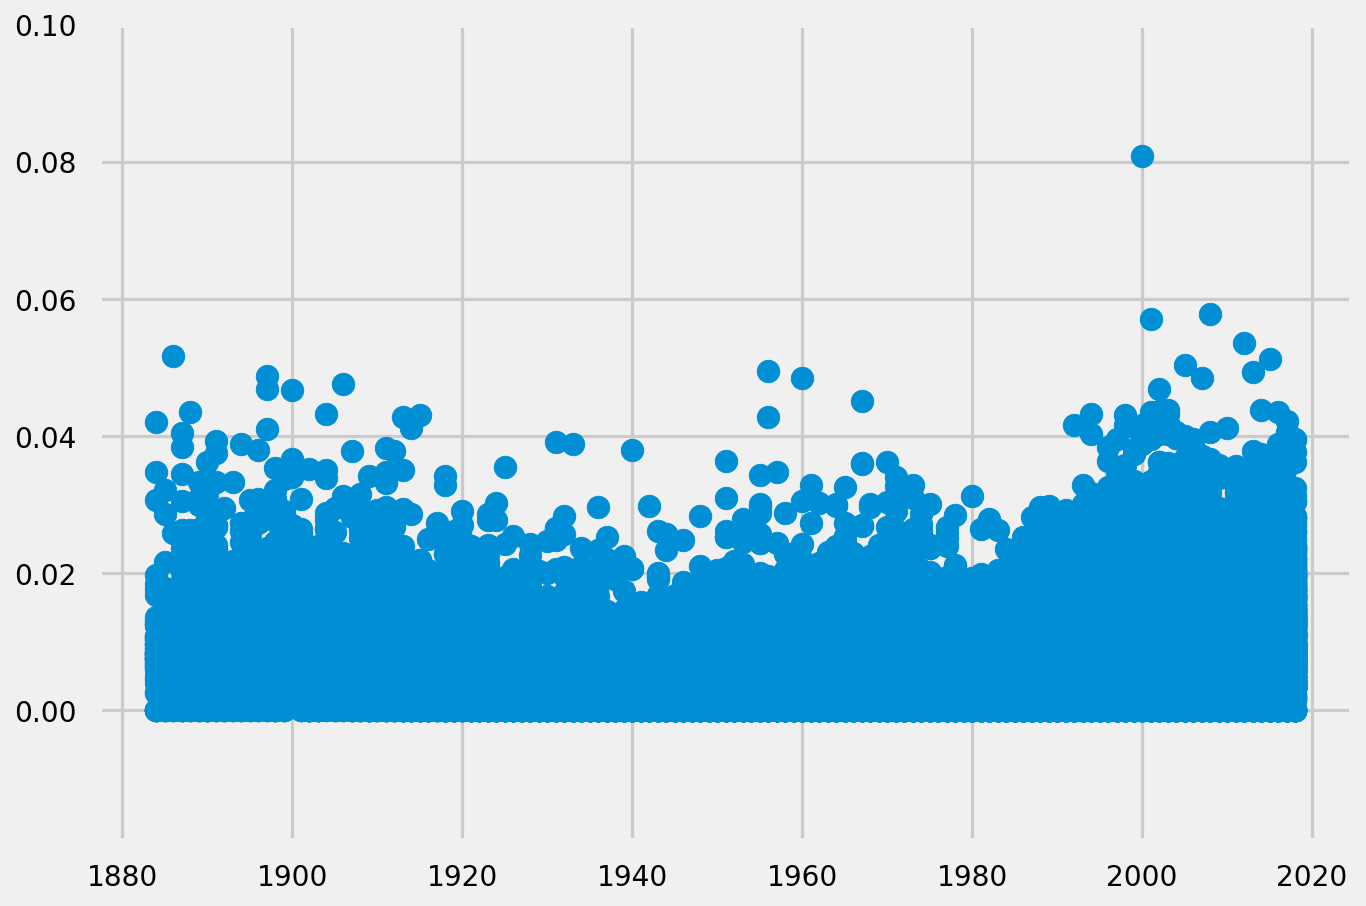

In [17]:
df = pitching.dropna(subset=['HBP', 'BFP'])
df = df[df['BFP'] > 100]
x = df['yearID']
y = df['HBP'] / df['BFP']
plt.scatter(x, y)

Wait, what's that strange outlier near the year 2000?

First, the ratio of HBP to batters faced is going to continue to come in useful, so let me add it directly to the dataframe. I'm calling it the `Plunk_Ratio`.

In [18]:
df['Plunk_Ratio'] = df['HBP'] / df['BFP']

In [19]:
df.loc[df['Plunk_Ratio'] > 0.08]

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,Plunk_Ratio
33138,hershor01,2000,1,LAN,NL,1,5,10,6,0,0,0,74,42,36,5,14,13,0.389,13.14,1.0,2,11.0,0,136.0,1,36,0.0,3.0,4.0,0.080882


In [20]:
people.loc[people['playerID'] == 'hershor01']

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
7812,hershor01,1958.0,9.0,16.0,USA,NY,Buffalo,NaN,NaN,NaN,NaN,NaN,NaN,Orel,Hershiser,Orel Leonard,190.0,75.0,R,R,1983-09-01,2000-06-26,herso001,hershor01


Okay so Cy Young award winner Orel Hershiser is our outlier! He plunked 11 batters in 2000 having only faced 136. That was the last year of his career, and he only started 6 games.

Earlier I calculated the Plunk Ratio when I charted, but since earlier I added the handy column `Plunk_Ratio` I can just use that in my plotting.

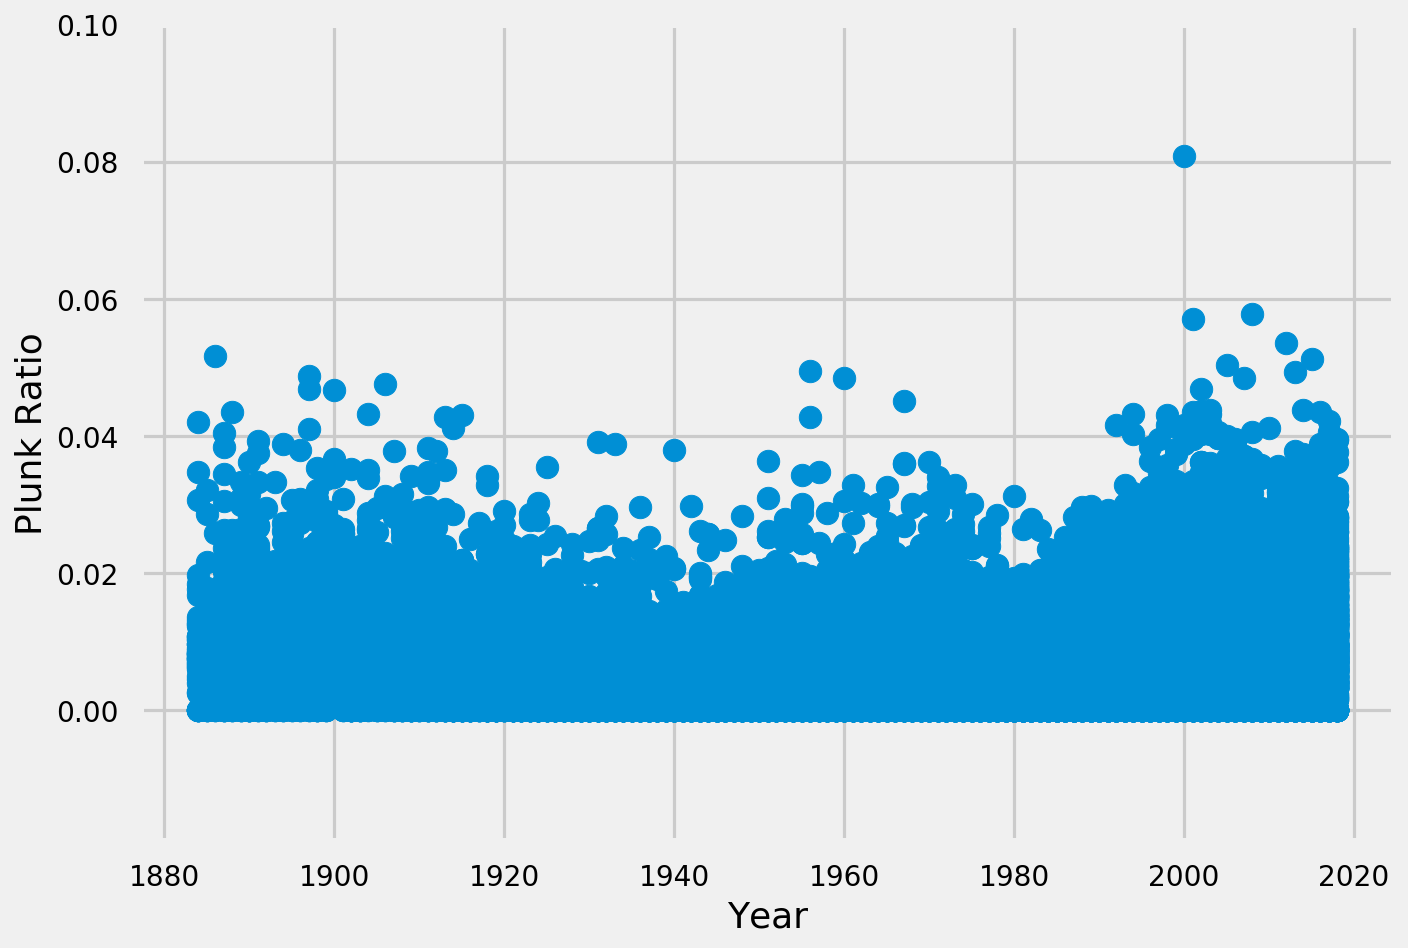

In [21]:
plt.xlabel('Year')
plt.ylabel('Plunk Ratio')
x = df['yearID']
y = df['Plunk_Ratio']
plt.scatter(x, y)

It's interesting that pitchers' Plunk Ratios declined in the period around WWII.

(array([1.1459e+04, 9.2210e+03, 5.6460e+03, 2.7670e+03, 1.5820e+03,
        6.5400e+02, 3.1700e+02, 1.6400e+02, 7.4000e+01, 4.6000e+01,
        3.1000e+01, 7.0000e+00, 6.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.        , 0.00404412, 0.00808824, 0.01213235, 0.01617647,
        0.02022059, 0.02426471, 0.02830882, 0.03235294, 0.03639706,
        0.04044118, 0.04448529, 0.04852941, 0.05257353, 0.05661765,
        0.06066176, 0.06470588, 0.06875   , 0.07279412, 0.07683824,
        0.08088235]),
 <a list of 20 Patch objects>)

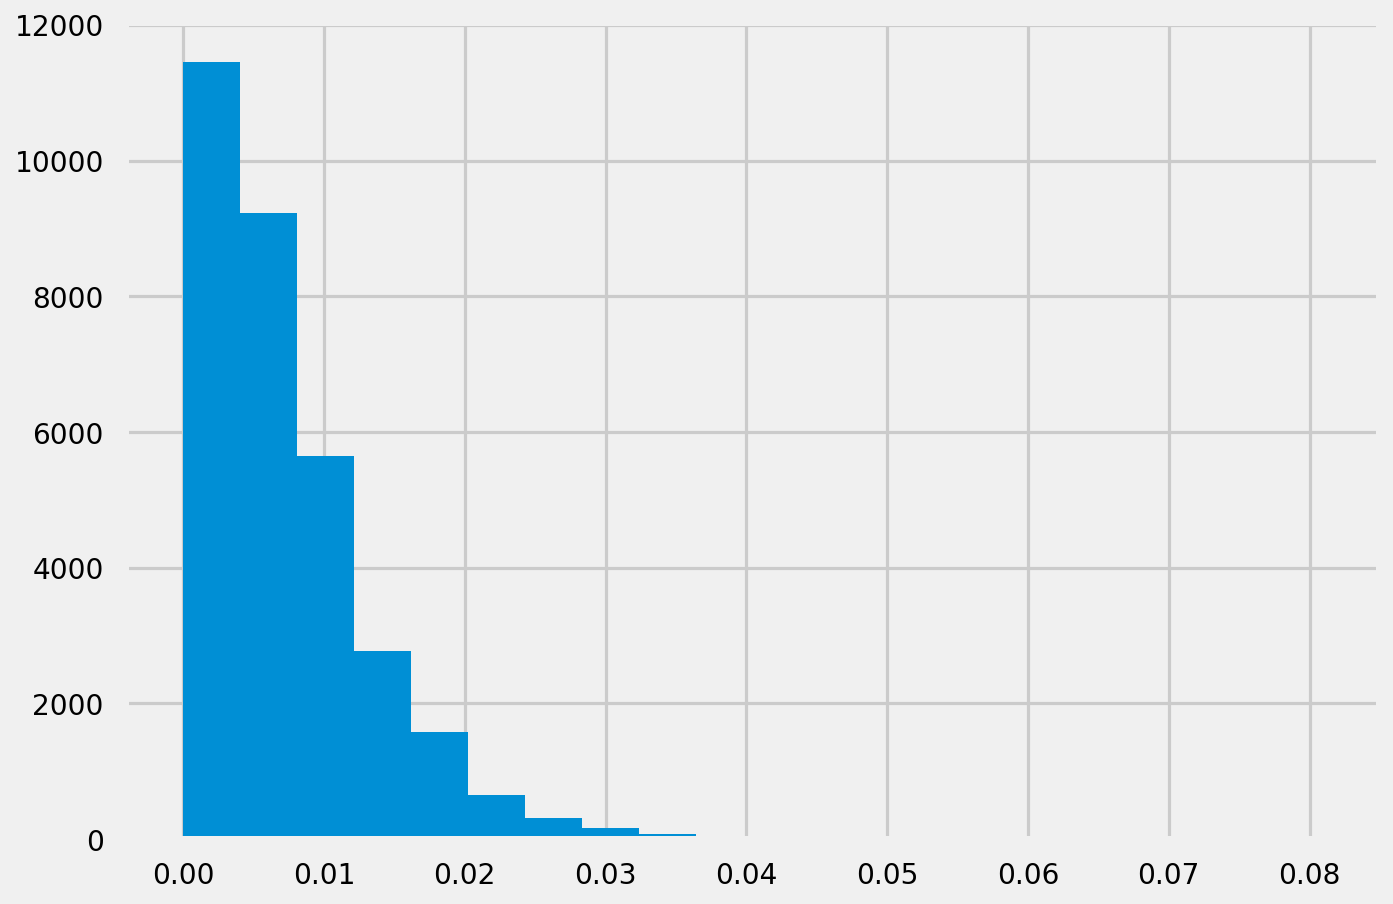

In [22]:
plt.hist(y, bins=20)

The dataset includes a pitching value called `stint` which reflects the order of appearances in a season. In a pitching rotation, your "ace" usually is your first starter, followed by your second best starter, etc. I was curious if there's any relationship between `Plunk_Ratio` and stint. One hypothesis is that harder throwers are more likely to hit batters, and harder throwers are more likely to be aces.

In [23]:
pitching.stint.unique()

array([1, 2, 3, 4, 5])

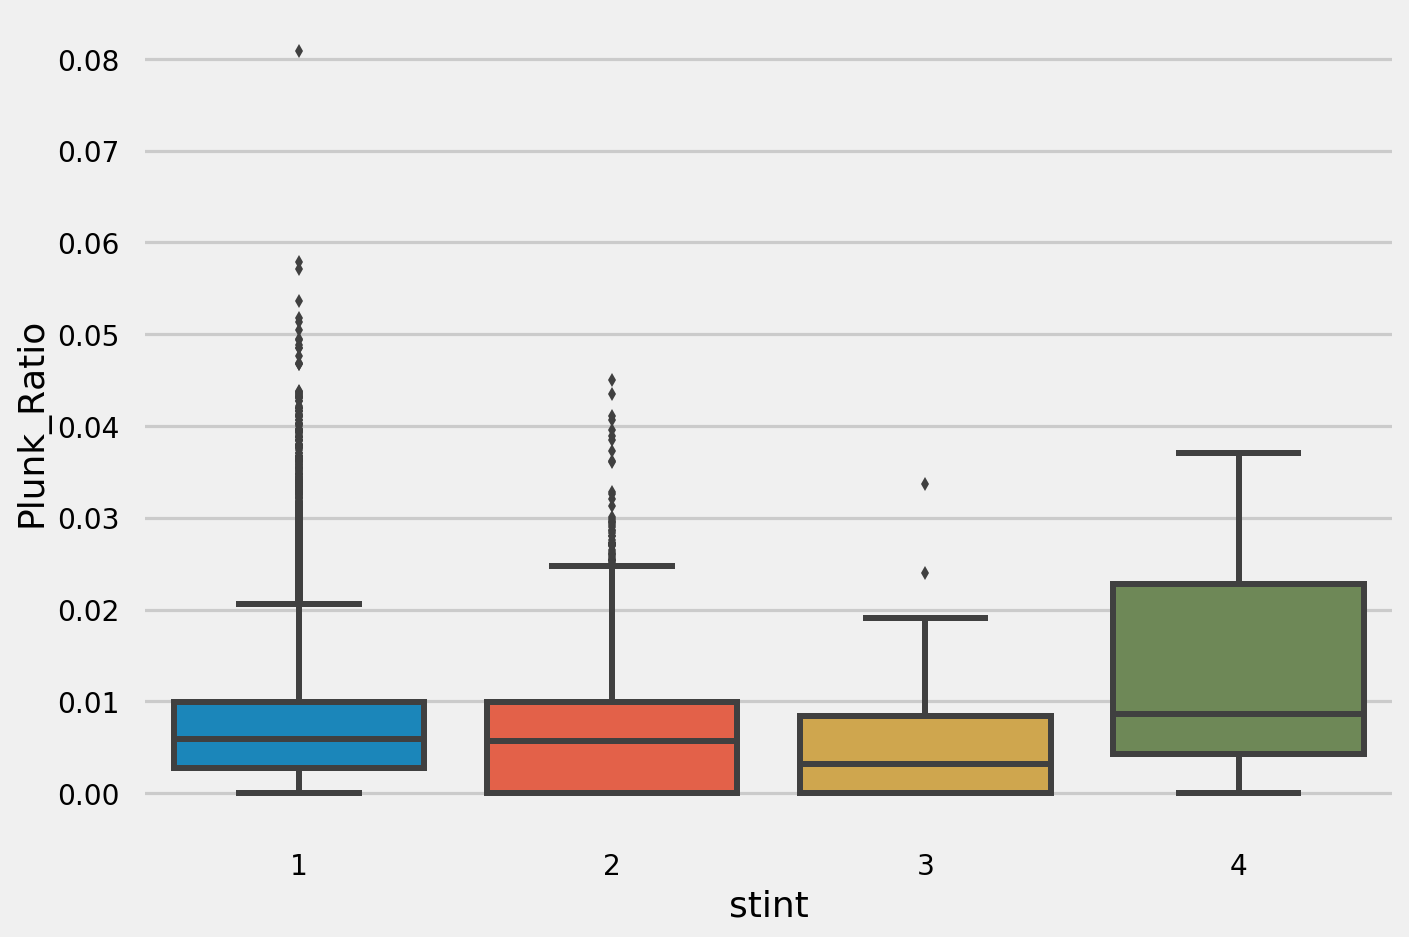

In [24]:
sns.boxplot(x="stint", y="Plunk_Ratio", data=df)

We can also look at the relationship between strikeouts and HBPs. As we can see, there is a relationship, and pitchers that strike out more batters are more likely to hit batters.

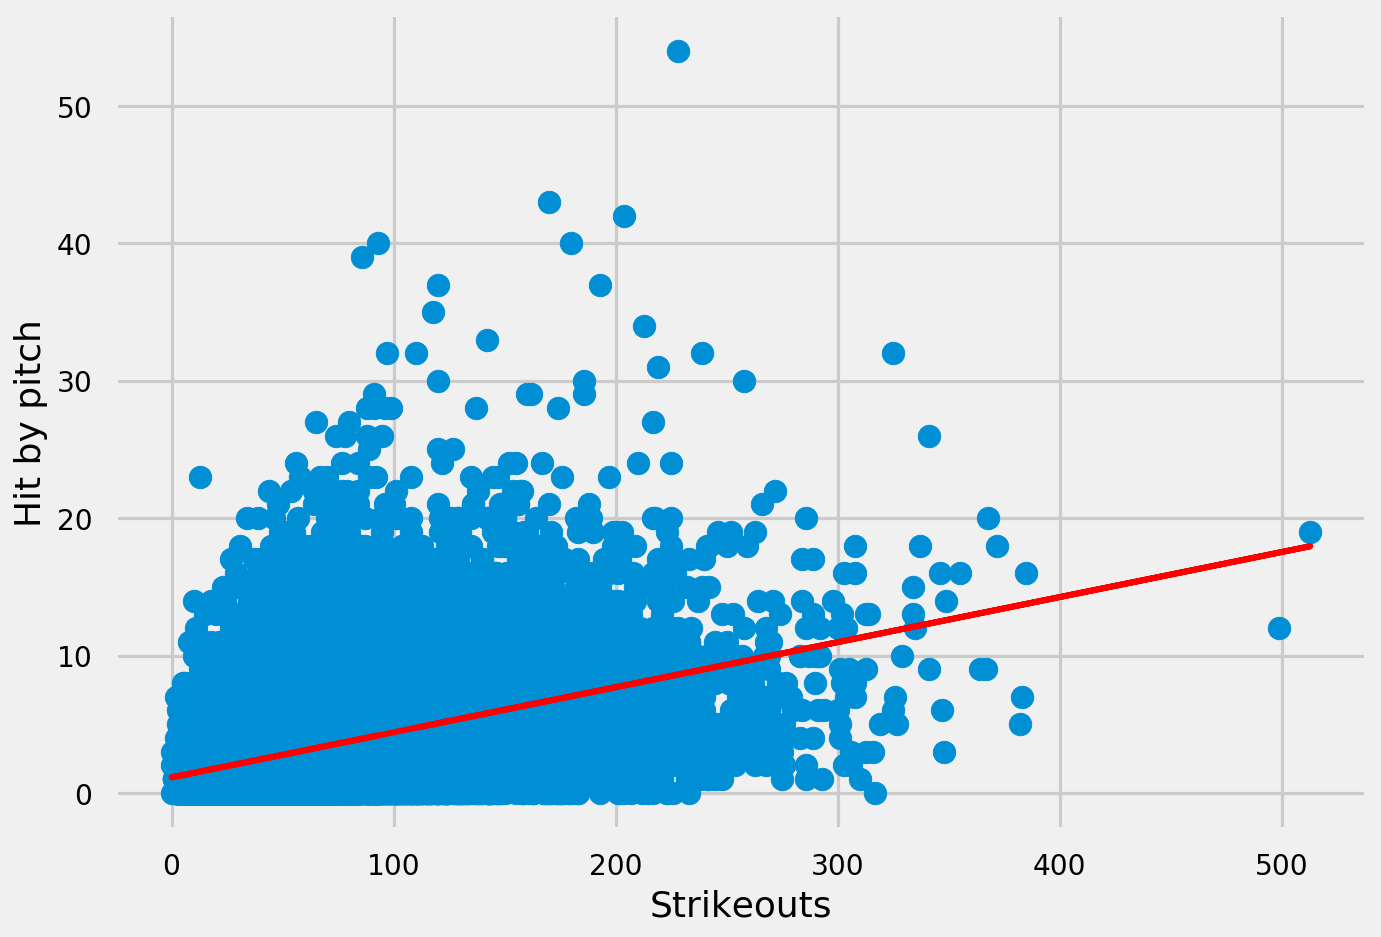

In [25]:
plt.xlabel('Strikeouts')
plt.ylabel('Hit by pitch')
x = df['SO']
y = df['HBP']
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

In [26]:
correlation(pitching['SO'], pitching['HBP'])

0.572213549679118

## Teams

Let's take a look at the Teams table. Here are the individual columns:

```
yearID         Year
lgID           League
teamID         Team
franchID       Franchise (links to TeamsFranchise table)
divID          Team's division
Rank           Position in final standings
G              Games played
GHome          Games played at home
W              Wins
L              Losses
DivWin         Division Winner (Y or N)
WCWin          Wild Card Winner (Y or N)
LgWin          League Champion(Y or N)
WSWin          World Series Winner (Y or N)
R              Runs scored
AB             At bats
H              Hits by batters
2B             Doubles
3B             Triples
HR             Homeruns by batters
BB             Walks by batters
SO             Strikeouts by batters
SB             Stolen bases
CS             Caught stealing
HBP            Batters hit by pitch
SF             Sacrifice flies
RA             Opponents runs scored
ER             Earned runs allowed
ERA            Earned run average
CG             Complete games
SHO            Shutouts
SV             Saves
IPOuts         Outs Pitched (innings pitched x 3)
HA             Hits allowed
HRA            Homeruns allowed
BBA            Walks allowed
SOA            Strikeouts by pitchers
E              Errors
DP             Double Plays
FP             Fielding  percentage
name           Team's full name
park           Name of team's home ballpark
attendance     Home attendance total
BPF            Three-year park factor for batters
PPF            Three-year park factor for pitchers
teamIDBR       Team ID used by Baseball Reference website
teamIDlahman45 Team ID used in Lahman database version 4.5
teamIDretro    Team ID used by Retrosheet
```

In [27]:
teams.describe()

,yearID,Rank,G,Ghome,W,L,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,attendance,BPF,PPF
count,2895.000000,2895.000000,2895.000000,2496.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2894.000000,2879.000000,2769.000000,2063.000000,1737.000000,1354.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2.616000e+03,2895.000000,2895.000000
mean,1956.963040,4.072539,150.692919,78.556891,74.942314,74.942314,683.611744,5154.547496,1347.913644,229.140933,46.506736,103.967530,475.229440,751.031956,111.022391,47.691226,45.364421,45.047267,683.610708,574.138860,3.823174,48.980656,9.685665,24.216235,4032.811744,1347.686356,103.967530,475.424870,750.522971,184.138860,133.539551,0.965802,1.380458e+06,100.194128,100.217271
std,42.260337,2.308810,22.968790,4.638081,17.530459,17.274056,134.572259,741.546183,216.989317,58.673209,22.260486,62.781245,130.915516,308.694949,70.055574,21.573868,17.689532,9.231481,134.023139,146.963575,0.762745,39.056428,5.032649,16.351810,623.227983,216.955229,59.625974,130.396145,309.842690,108.208599,35.302549,0.029347,9.578068e+05,4.919002,4.846016
min,1871.000000,1.000000,6.000000,44.000000,0.000000,4.000000,24.000000,211.000000,33.000000,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,3.000000,7.000000,18.000000,34.000000,23.000000,1.220000,0.000000,0.000000,0.000000,162.000000,49.000000,0.000000,1.000000,0.000000,47.000000,0.000000,0.761000,6.088000e+03,60.000000,60.000000
25%,1921.000000,2.000000,154.000000,77.000000,66.000000,66.000000,615.000000,5142.000000,1303.000000,195.000000,30.000000,43.000000,427.000000,513.500000,64.000000,34.000000,32.000000,39.000000,611.000000,504.000000,3.360000,11.000000,6.000000,9.000000,4080.000000,1290.500000,49.000000,430.000000,506.500000,114.000000,117.000000,0.965000,5.447818e+05,97.000000,97.000000
50%,1965.000000,4.000000,158.000000,81.000000,77.000000,76.000000,691.000000,5404.000000,1393.000000,233.000000,41.000000,109.000000,494.000000,755.000000,94.000000,45.000000,43.000000,45.000000,689.000000,594.000000,3.830000,43.000000,9.000000,25.000000,4251.000000,1392.000000,112.000000,496.000000,754.000000,143.000000,141.000000,0.977000,1.185781e+06,100.000000,100.000000
75%,1994.000000,6.000000,162.000000,81.000000,87.000000,87.000000,764.000000,5520.500000,1466.000000,272.000000,59.000000,153.000000,554.000000,980.500000,139.000000,57.000000,56.000000,51.000000,765.500000,669.000000,4.310000,77.000000,13.000000,38.000000,4342.000000,1470.000000,152.000000,554.000000,985.500000,212.000000,157.000000,0.981000,2.065338e+06,103.000000,103.000000
max,2018.000000,13.000000,165.000000,84.000000,116.000000,134.000000,1220.000000,5781.000000,1783.000000,376.000000,150.000000,267.000000,835.000000,1594.000000,581.000000,191.000000,160.000000,77.000000,1252.000000,1023.000000,8.000000,148.000000,32.000000,68.000000,4518.000000,1993.000000,258.000000,827.000000,1687.000000,639.000000,217.000000,0.991000,4.483350e+06,129.000000,141.000000


(array([ 12.,  11.,   4.,  12.,  13.,   6.,  21.,  21.,  33.,  48.,  61.,
        111., 132., 164., 279., 310., 300., 357., 364., 251., 227., 108.,
         35.,  12.,   3.]),
 array([  0.  ,   4.64,   9.28,  13.92,  18.56,  23.2 ,  27.84,  32.48,
         37.12,  41.76,  46.4 ,  51.04,  55.68,  60.32,  64.96,  69.6 ,
         74.24,  78.88,  83.52,  88.16,  92.8 ,  97.44, 102.08, 106.72,
        111.36, 116.  ]),
 <a list of 25 Patch objects>)

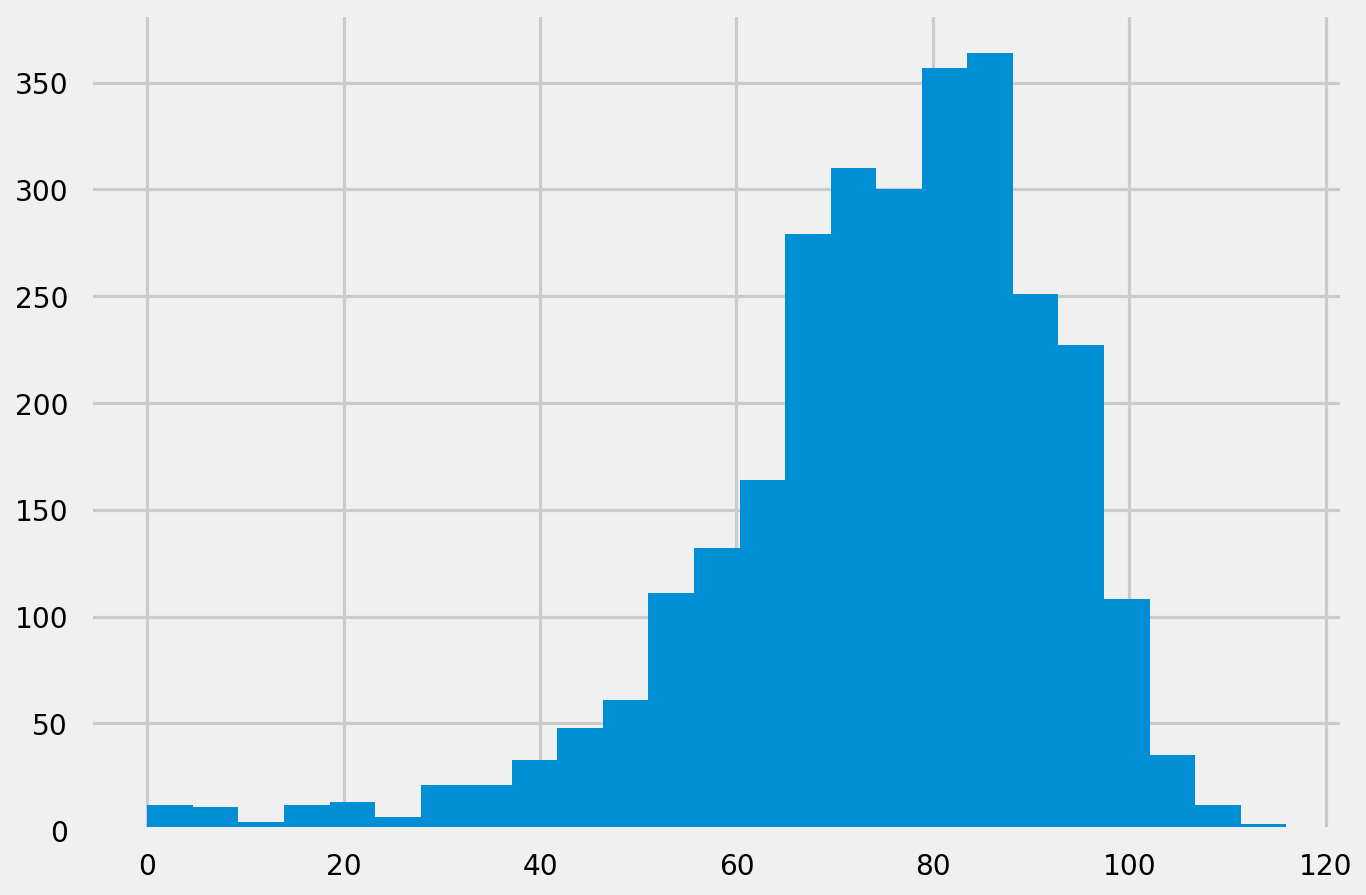

In [28]:
plt.hist(teams['W'], bins=25)

(array([  8.,   8.,  20.,  12.,  15.,  22.,  34.,  45.,  65.,  71., 210.,
        258., 325., 395., 338., 396., 269., 199., 116.,  57.,  26.,   3.,
          2.,   0.,   1.]),
 array([  4. ,   9.2,  14.4,  19.6,  24.8,  30. ,  35.2,  40.4,  45.6,
         50.8,  56. ,  61.2,  66.4,  71.6,  76.8,  82. ,  87.2,  92.4,
         97.6, 102.8, 108. , 113.2, 118.4, 123.6, 128.8, 134. ]),
 <a list of 25 Patch objects>)

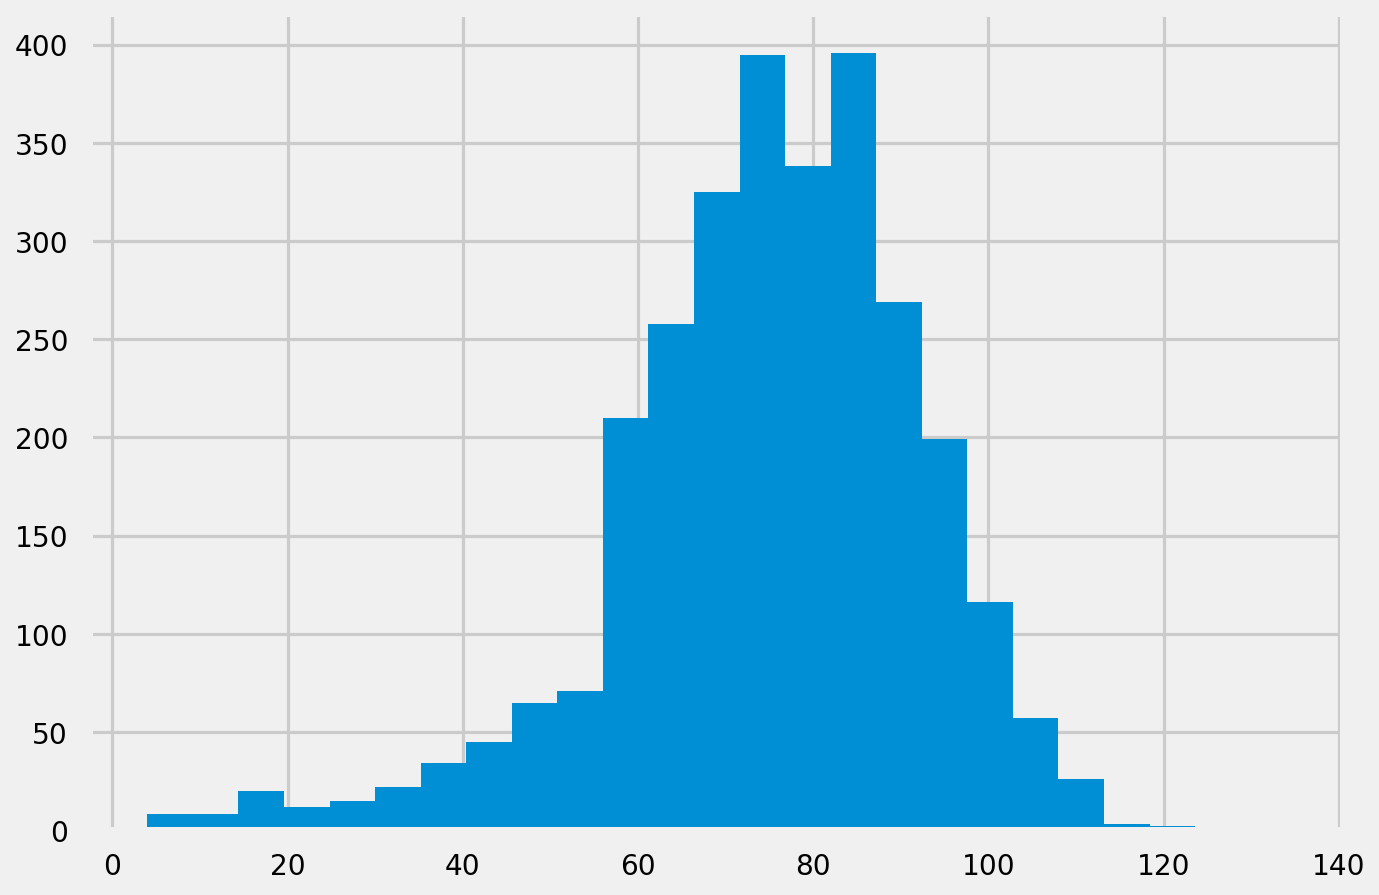

In [29]:
plt.hist(teams['L'], bins=25)

In [30]:
teams['Win_Pct'] = teams['W'] / (teams['W'] + teams['L'])

(array([  2.,   1.,   3.,   4.,   5.,   8.,  13.,  24.,  42., 106., 155.,
        271., 381., 426., 450., 430., 306., 152.,  69.,  30.,   9.,   4.,
          1.,   2.,   1.]),
 array([0.        , 0.03594937, 0.07189873, 0.1078481 , 0.14379747,
        0.17974684, 0.2156962 , 0.25164557, 0.28759494, 0.3235443 ,
        0.35949367, 0.39544304, 0.43139241, 0.46734177, 0.50329114,
        0.53924051, 0.57518987, 0.61113924, 0.64708861, 0.68303797,
        0.71898734, 0.75493671, 0.79088608, 0.82683544, 0.86278481,
        0.89873418]),
 <a list of 25 Patch objects>)

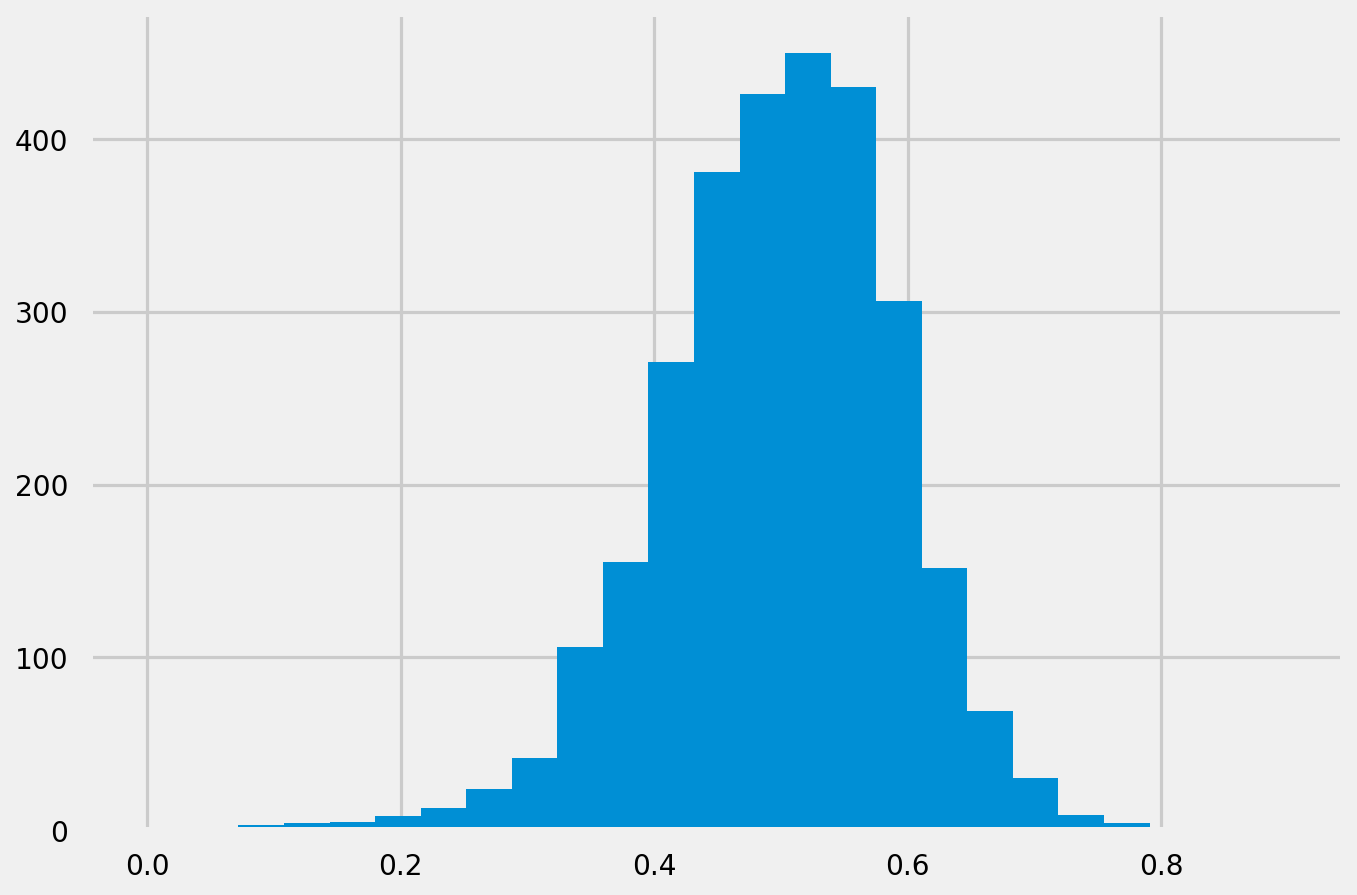

In [31]:
plt.hist(teams['Win_Pct'], bins=25)

### San Francisco Giants

The Giants are my favorite team, so I've decided to do some analysis of their stats over the years.

In [32]:
# Orange and black are the Giants colors!
# Make a fun little function to generate orange and black plots
plt.style.use('dark_background')
sfgcolor = '#FD5A1E'

def sfgplot(x, y, xtitle, ytitle):
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.fill_between(x, y, facecolor=sfgcolor)
    plt.plot(x, y, color=sfgcolor, linewidth=5)

In [33]:
# Teams are identified both with teamIDs and franchID (franchise IDs). The San Francisco Giants were 
# originally the New York Giants. If we selected only data with the SFN teamID, we'd miss out on 
# all of the stats from their years in NY. I want the full franchise history, so I'm going to filter 
# on franchID
sfg = teams[teams['franchID'] == 'SFG']
sfg.teamID.unique()

array(['NY1', 'SFN'], dtype=object)

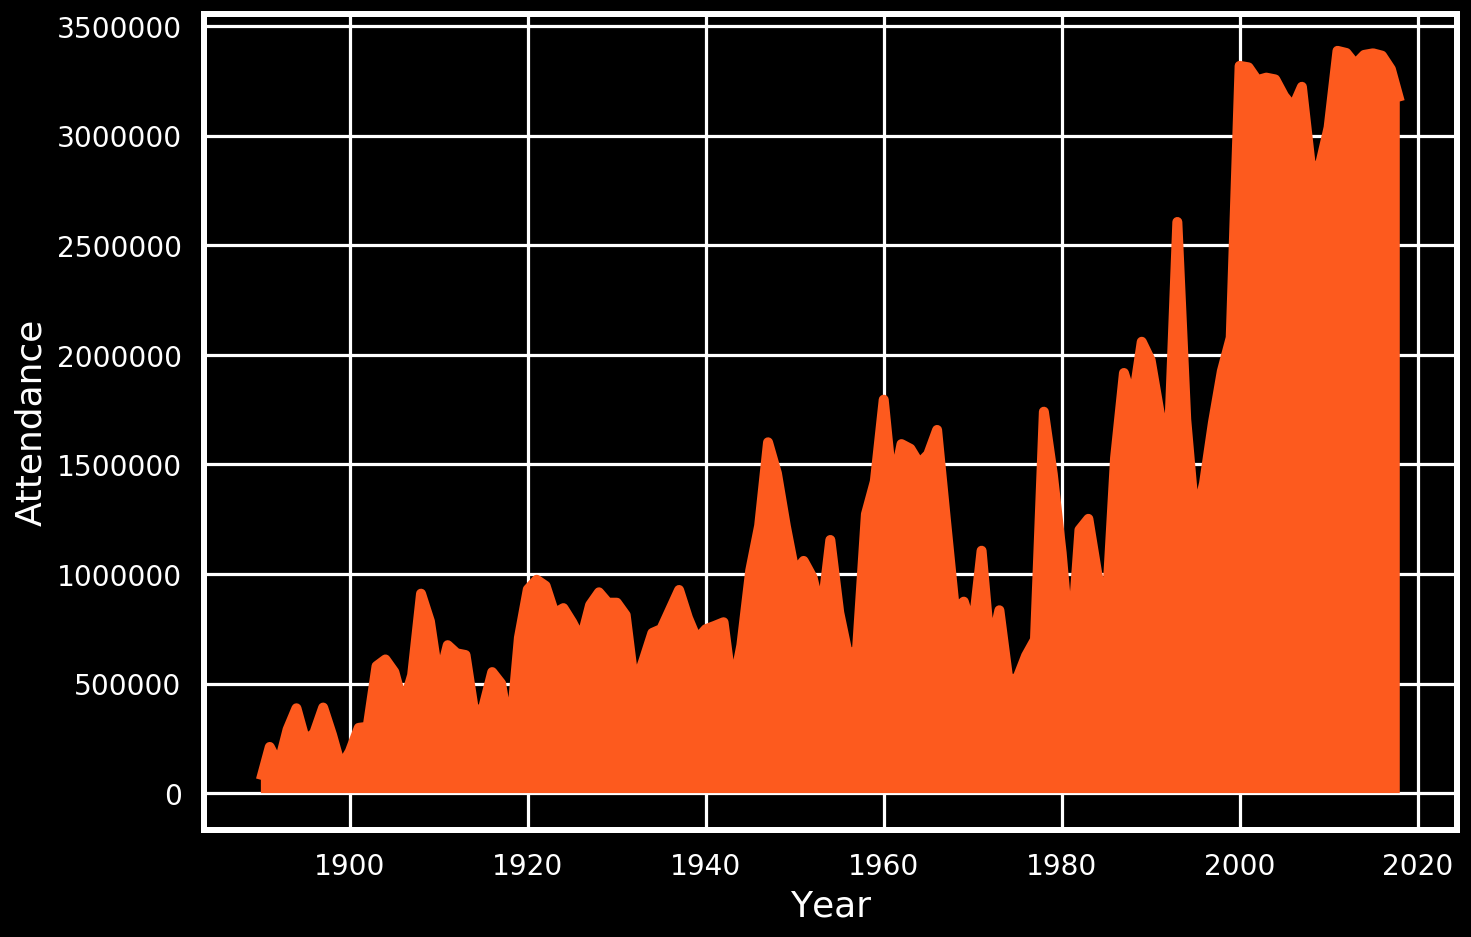

In [34]:
sfgplot(sfg['yearID'], sfg['attendance'], "Year", "Attendance")

It's cool that the data include attendance numbers. With the Giants, you can see the year they moved into their new stadium in San Franciso (2000) as well as their record-breaking attendance numbers since then, including through three World Series titles in 2010, 2012, and 2014.

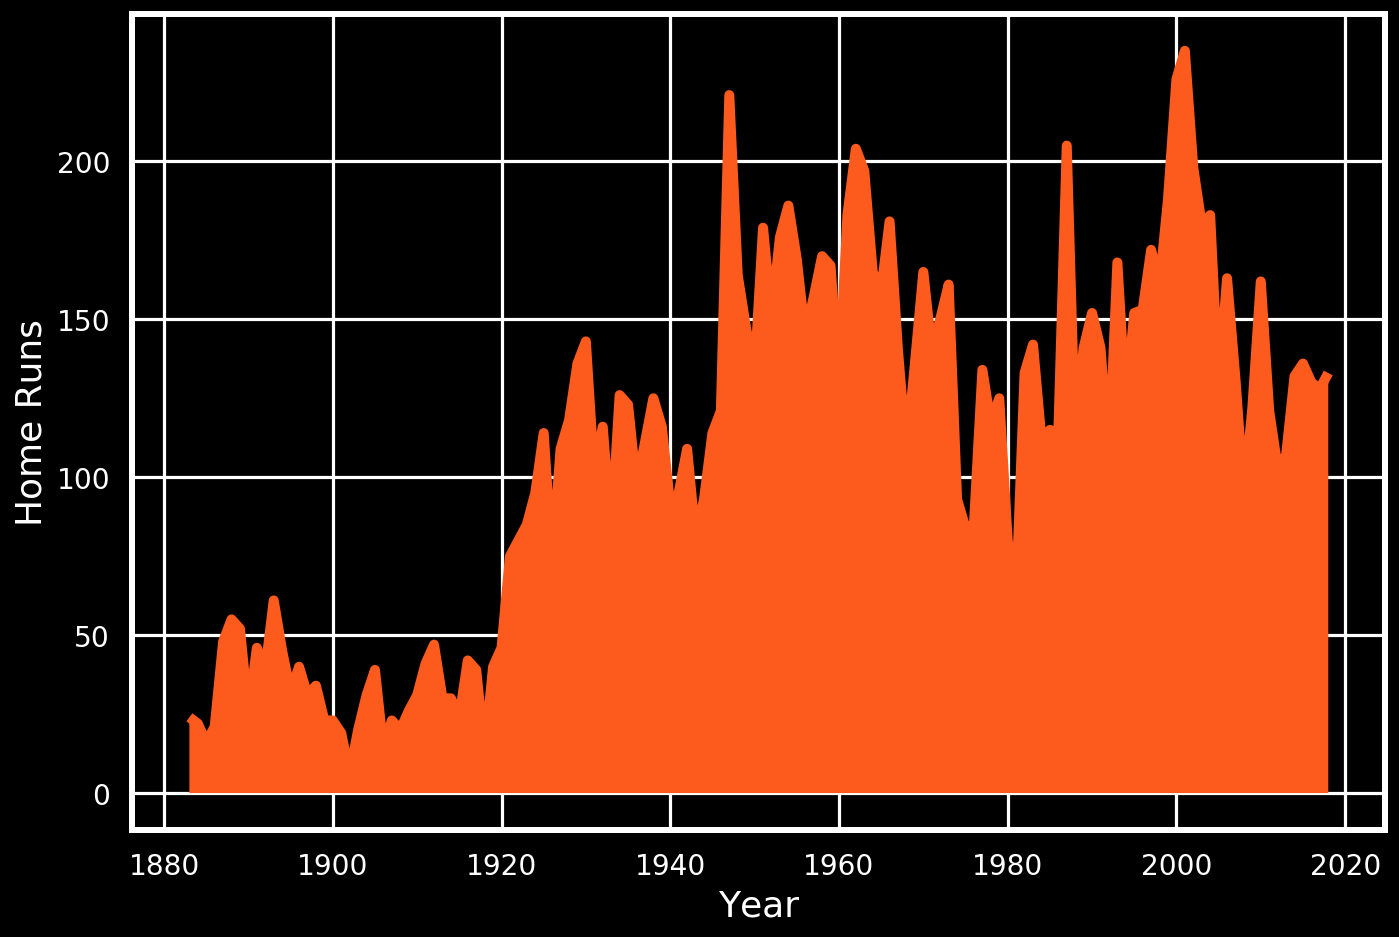

In [35]:
sfgplot(sfg['yearID'], sfg['HR'], "Year", "Home Runs")

Unsurprisingly, when you look at Giants home run totals throughout history you can clearly see Barry Bonds record-breaking years in the late 1990s/early 2000s.

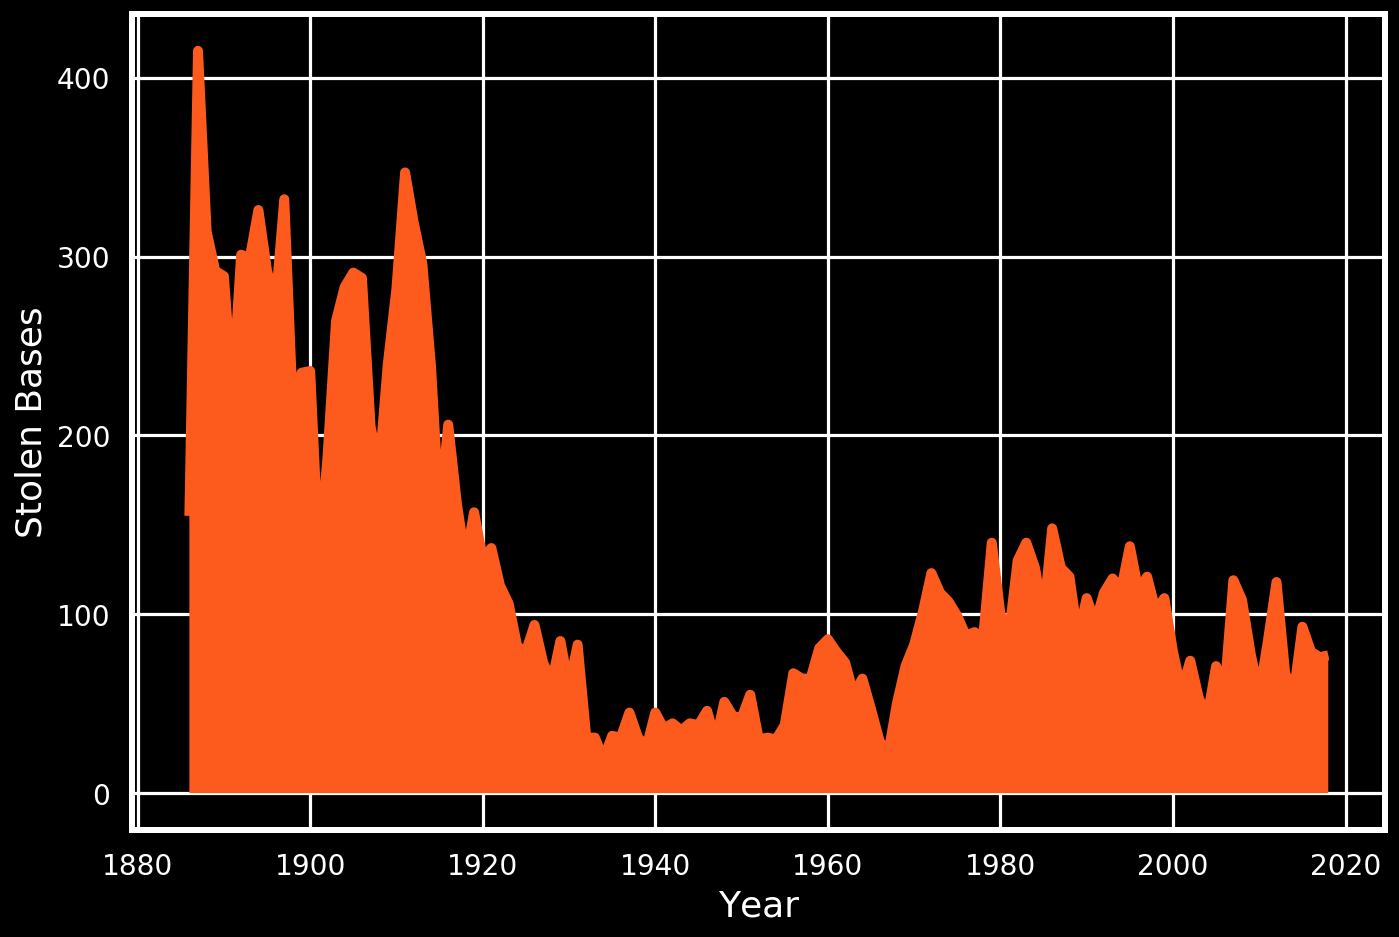

In [36]:
sfgplot(sfg['yearID'], sfg['SB'], "Year", "Stolen Bases")

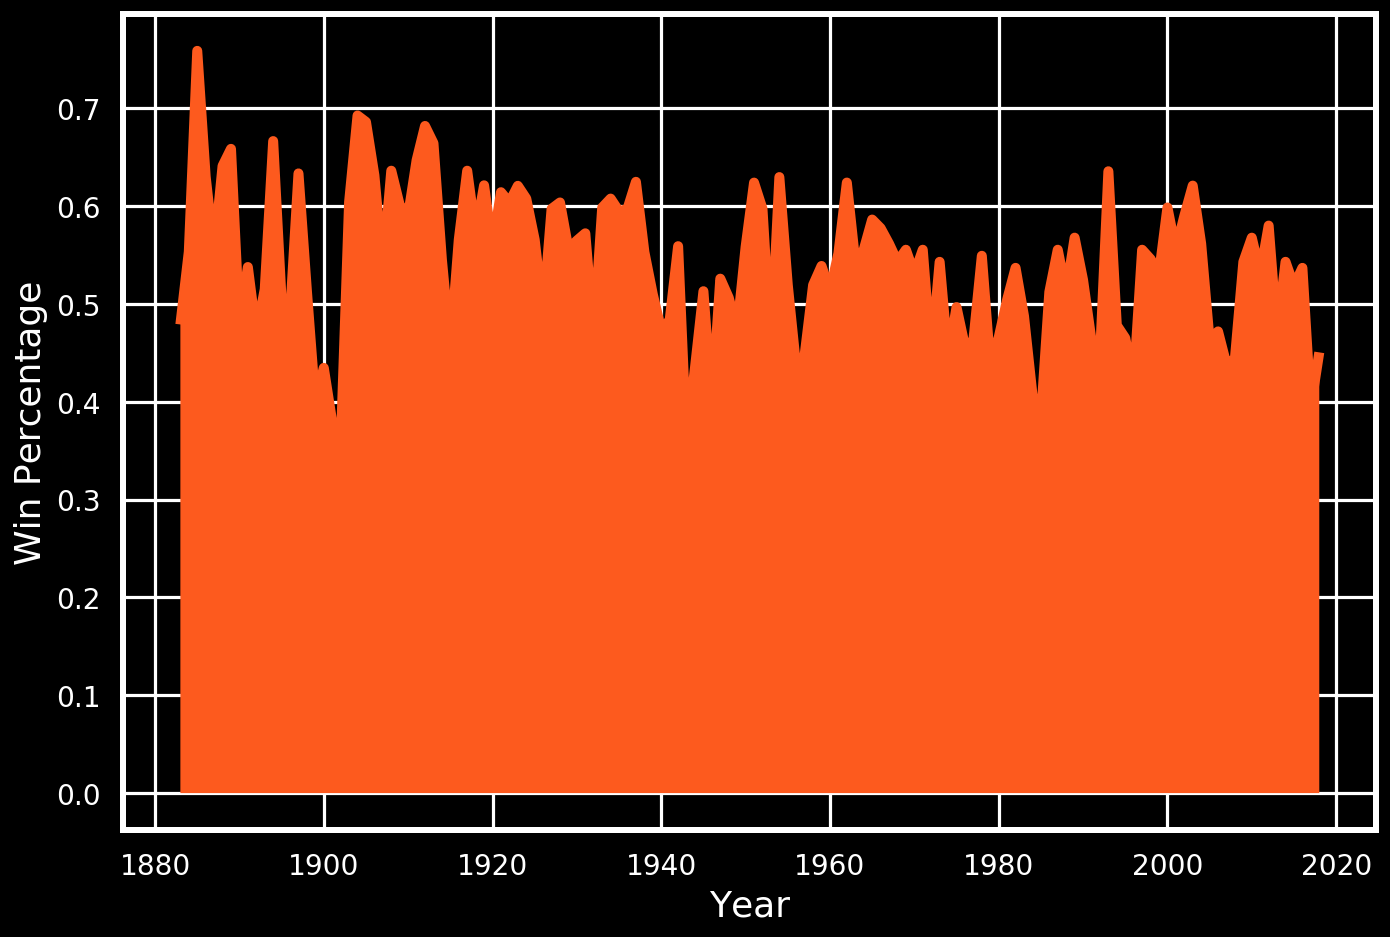

In [37]:
sfgplot(sfg['yearID'], sfg['Win_Pct'], "Year", "Win Percentage")

In what place (rank) did the Giants finish at the end of the season?

(array([26., 31., 26., 17., 17.,  8.,  3.,  6.,  1.,  1.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

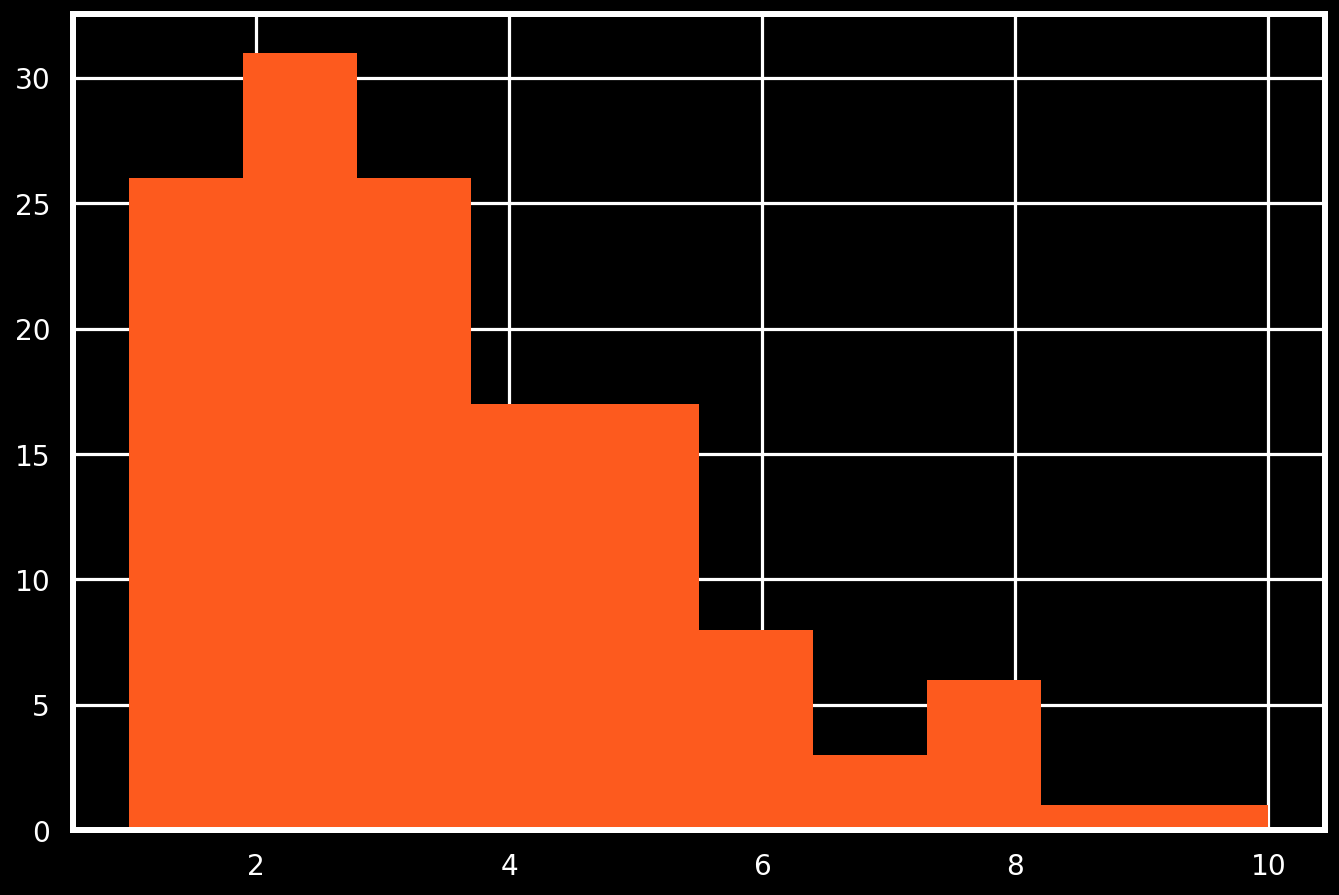

In [38]:
plt.hist(sfg['Rank'], color='#FD5A1E', bins=10)

How many World Series titles do the Giants have?

In [39]:
sfg[sfg['WSWin'] == "Y"]['yearID'].count()

10

In [40]:
sfg[sfg['WSWin'] == "Y"]['yearID']

215     1888
231     1889
455     1905
727     1921
743     1922
919     1933
1256    1954
2649    2010
2709    2012
2769    2014
Name: yearID, dtype: int64

## Hall of Fame

```
playerID       Player ID code
yearID         Year of ballot
votedBy        Method by which player was voted upon
ballots        Total ballots cast in that year
needed         Number of votes needed for selection in that year
votes          Total votes received
inducted       Whether player was inducted by that vote or not (Y or N)
category       Category in which candidate was honored
needed_note    Explanation of qualifiers for special elections
```

In [41]:
hof.describe()

,yearID,ballots,needed,votes
count,4191.000000,3994.000000,3837.000000,3994.000000
mean,1969.712956,322.574862,245.397707,51.934402
std,23.555073,125.265128,94.325990,86.137219
min,1936.000000,78.000000,59.000000,0.000000
25%,1950.000000,226.000000,175.000000,2.000000
50%,1966.000000,274.000000,213.000000,10.000000
75%,1989.000000,427.000000,323.000000,65.000000
max,2018.000000,581.000000,436.000000,555.000000


In [42]:
hof.category.unique()

array(['Player', 'Manager', 'Pioneer/Executive', 'Umpire'], dtype=object)

We only want to look at players, so let's narrow the set and then join it with the people table.

In [43]:
hof = hof[hof['category'] == 'Player']
hofers = pd.merge(people, hof, on='playerID', how='inner')
hofers.playerID.nunique()

1227

In [44]:
# Reset all of the Giants styles
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

(array([ 45., 171., 385., 835., 628., 660., 516., 447., 333.,  46.]),
 array([1845. , 1859.2, 1873.4, 1887.6, 1901.8, 1916. , 1930.2, 1944.4,
        1958.6, 1972.8, 1987. ]),
 <a list of 10 Patch objects>)

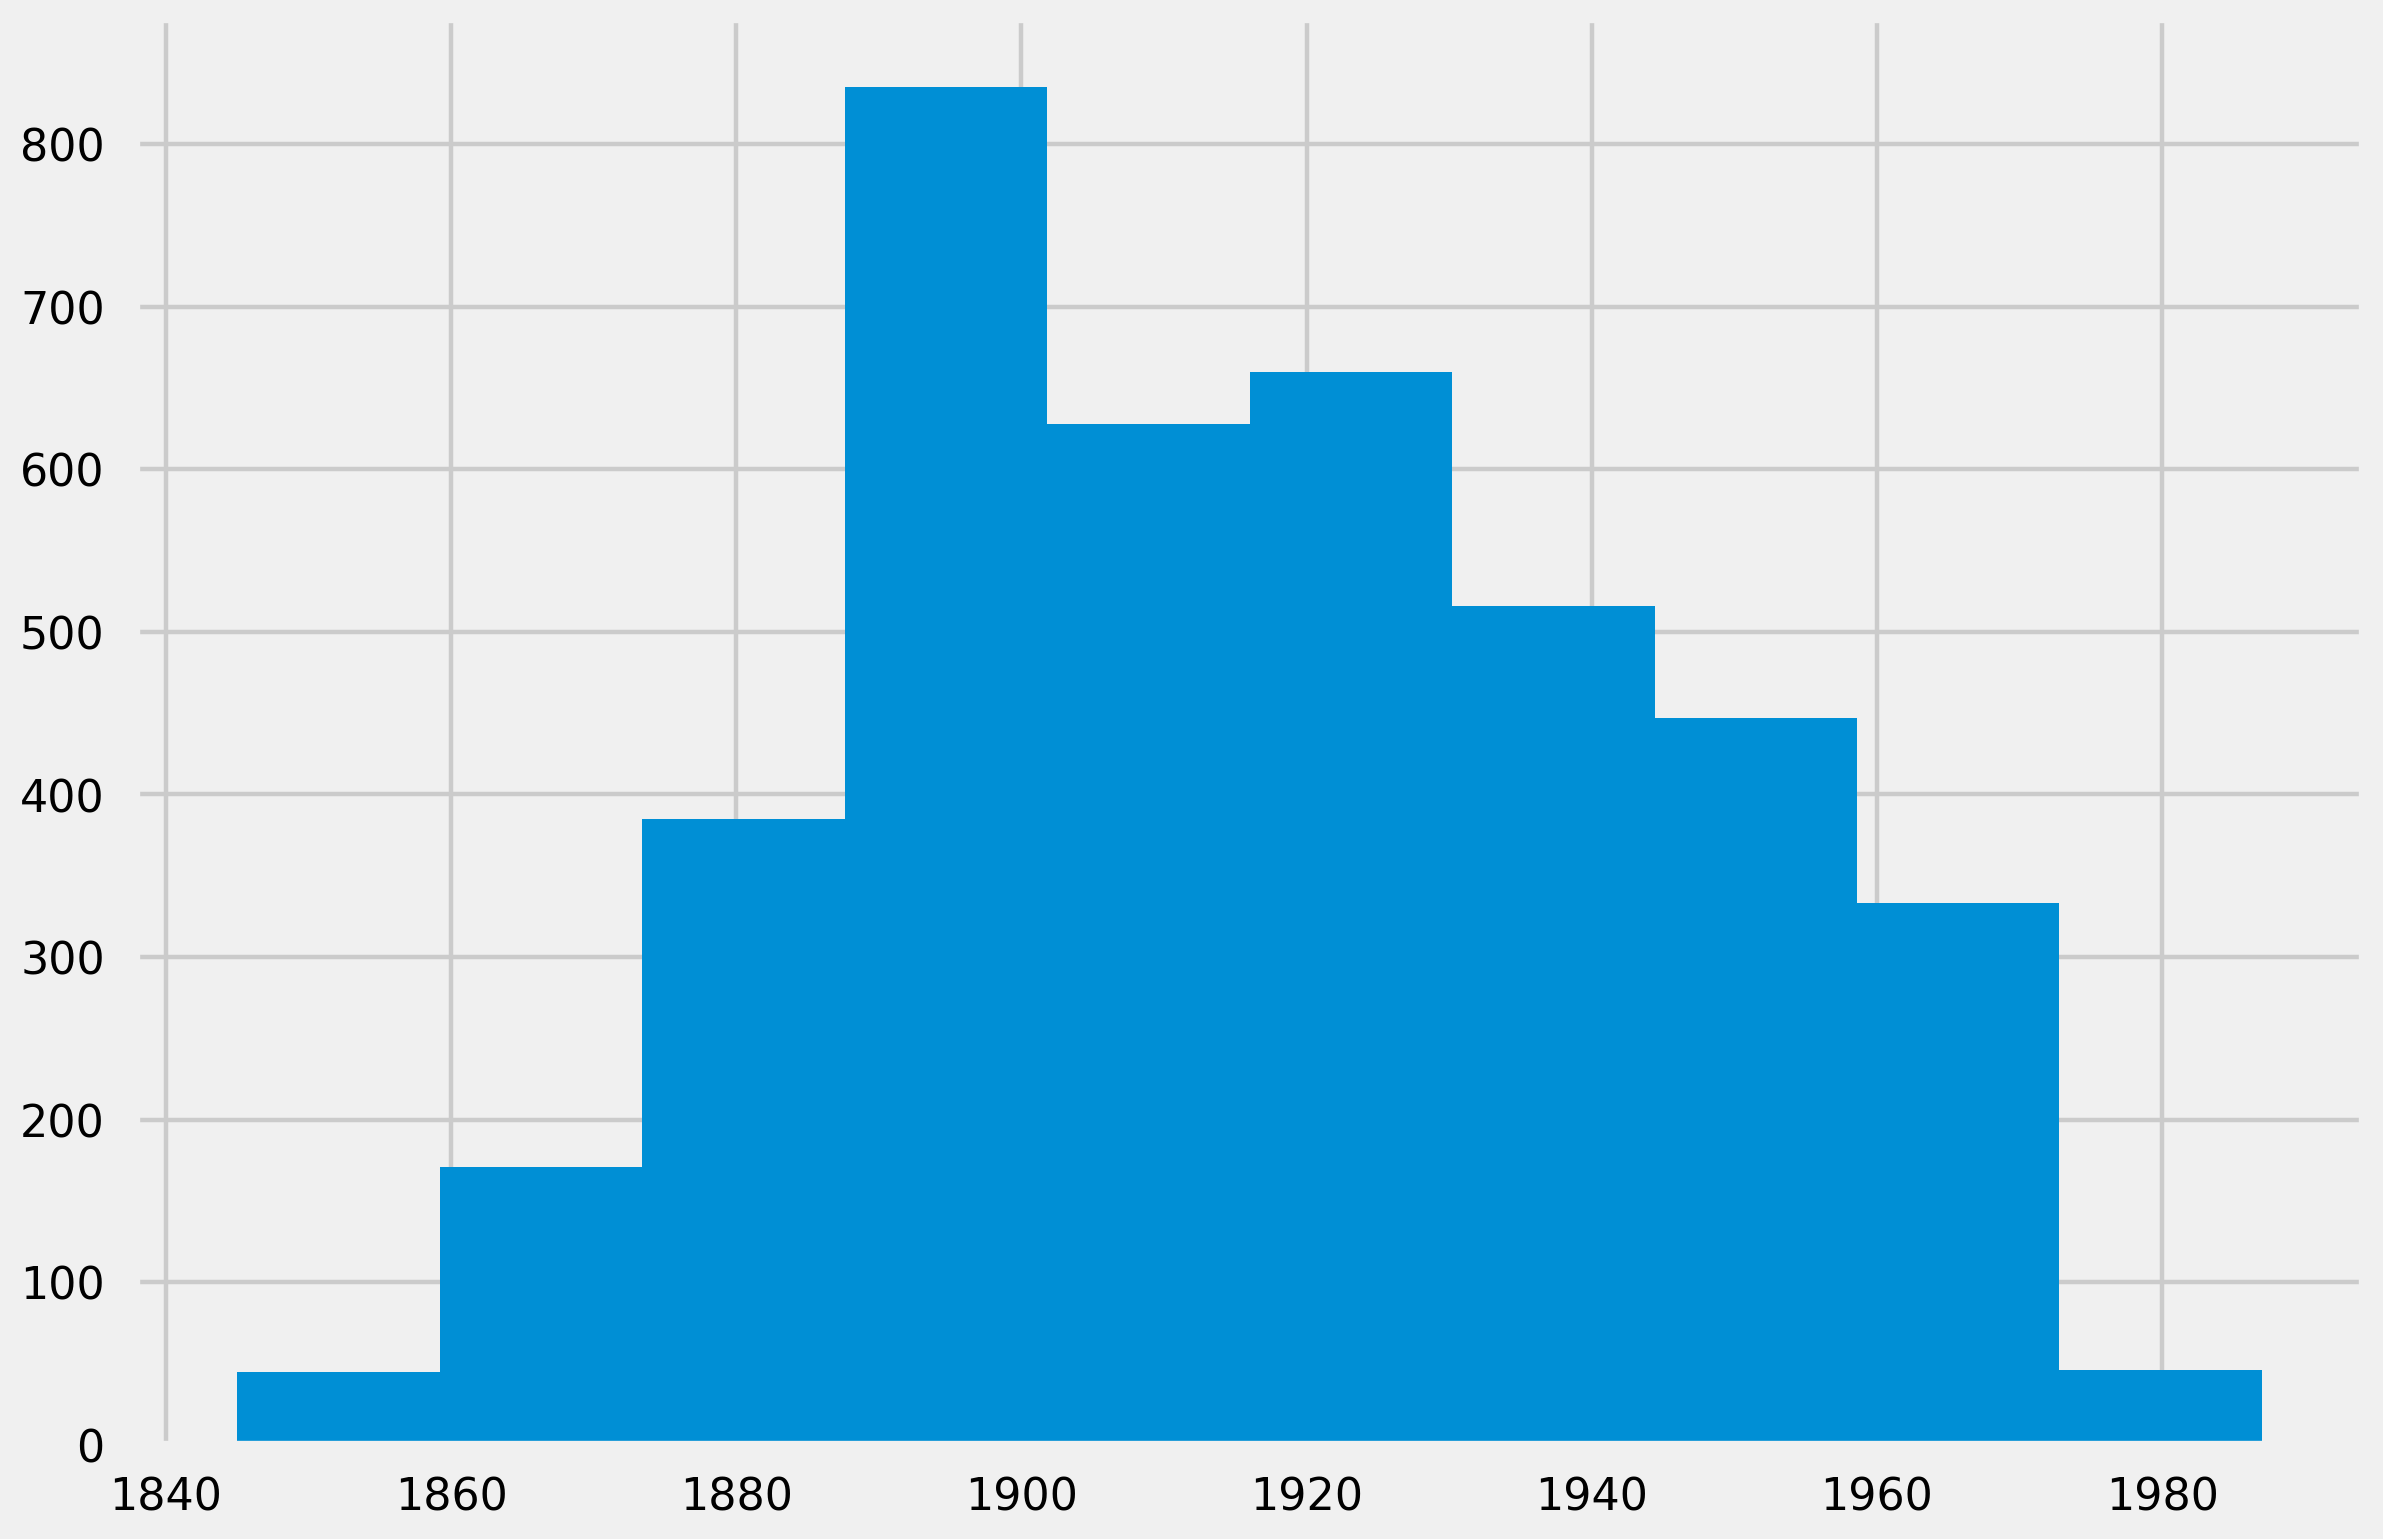

In [45]:
plt.hist(hofers['birthYear'])

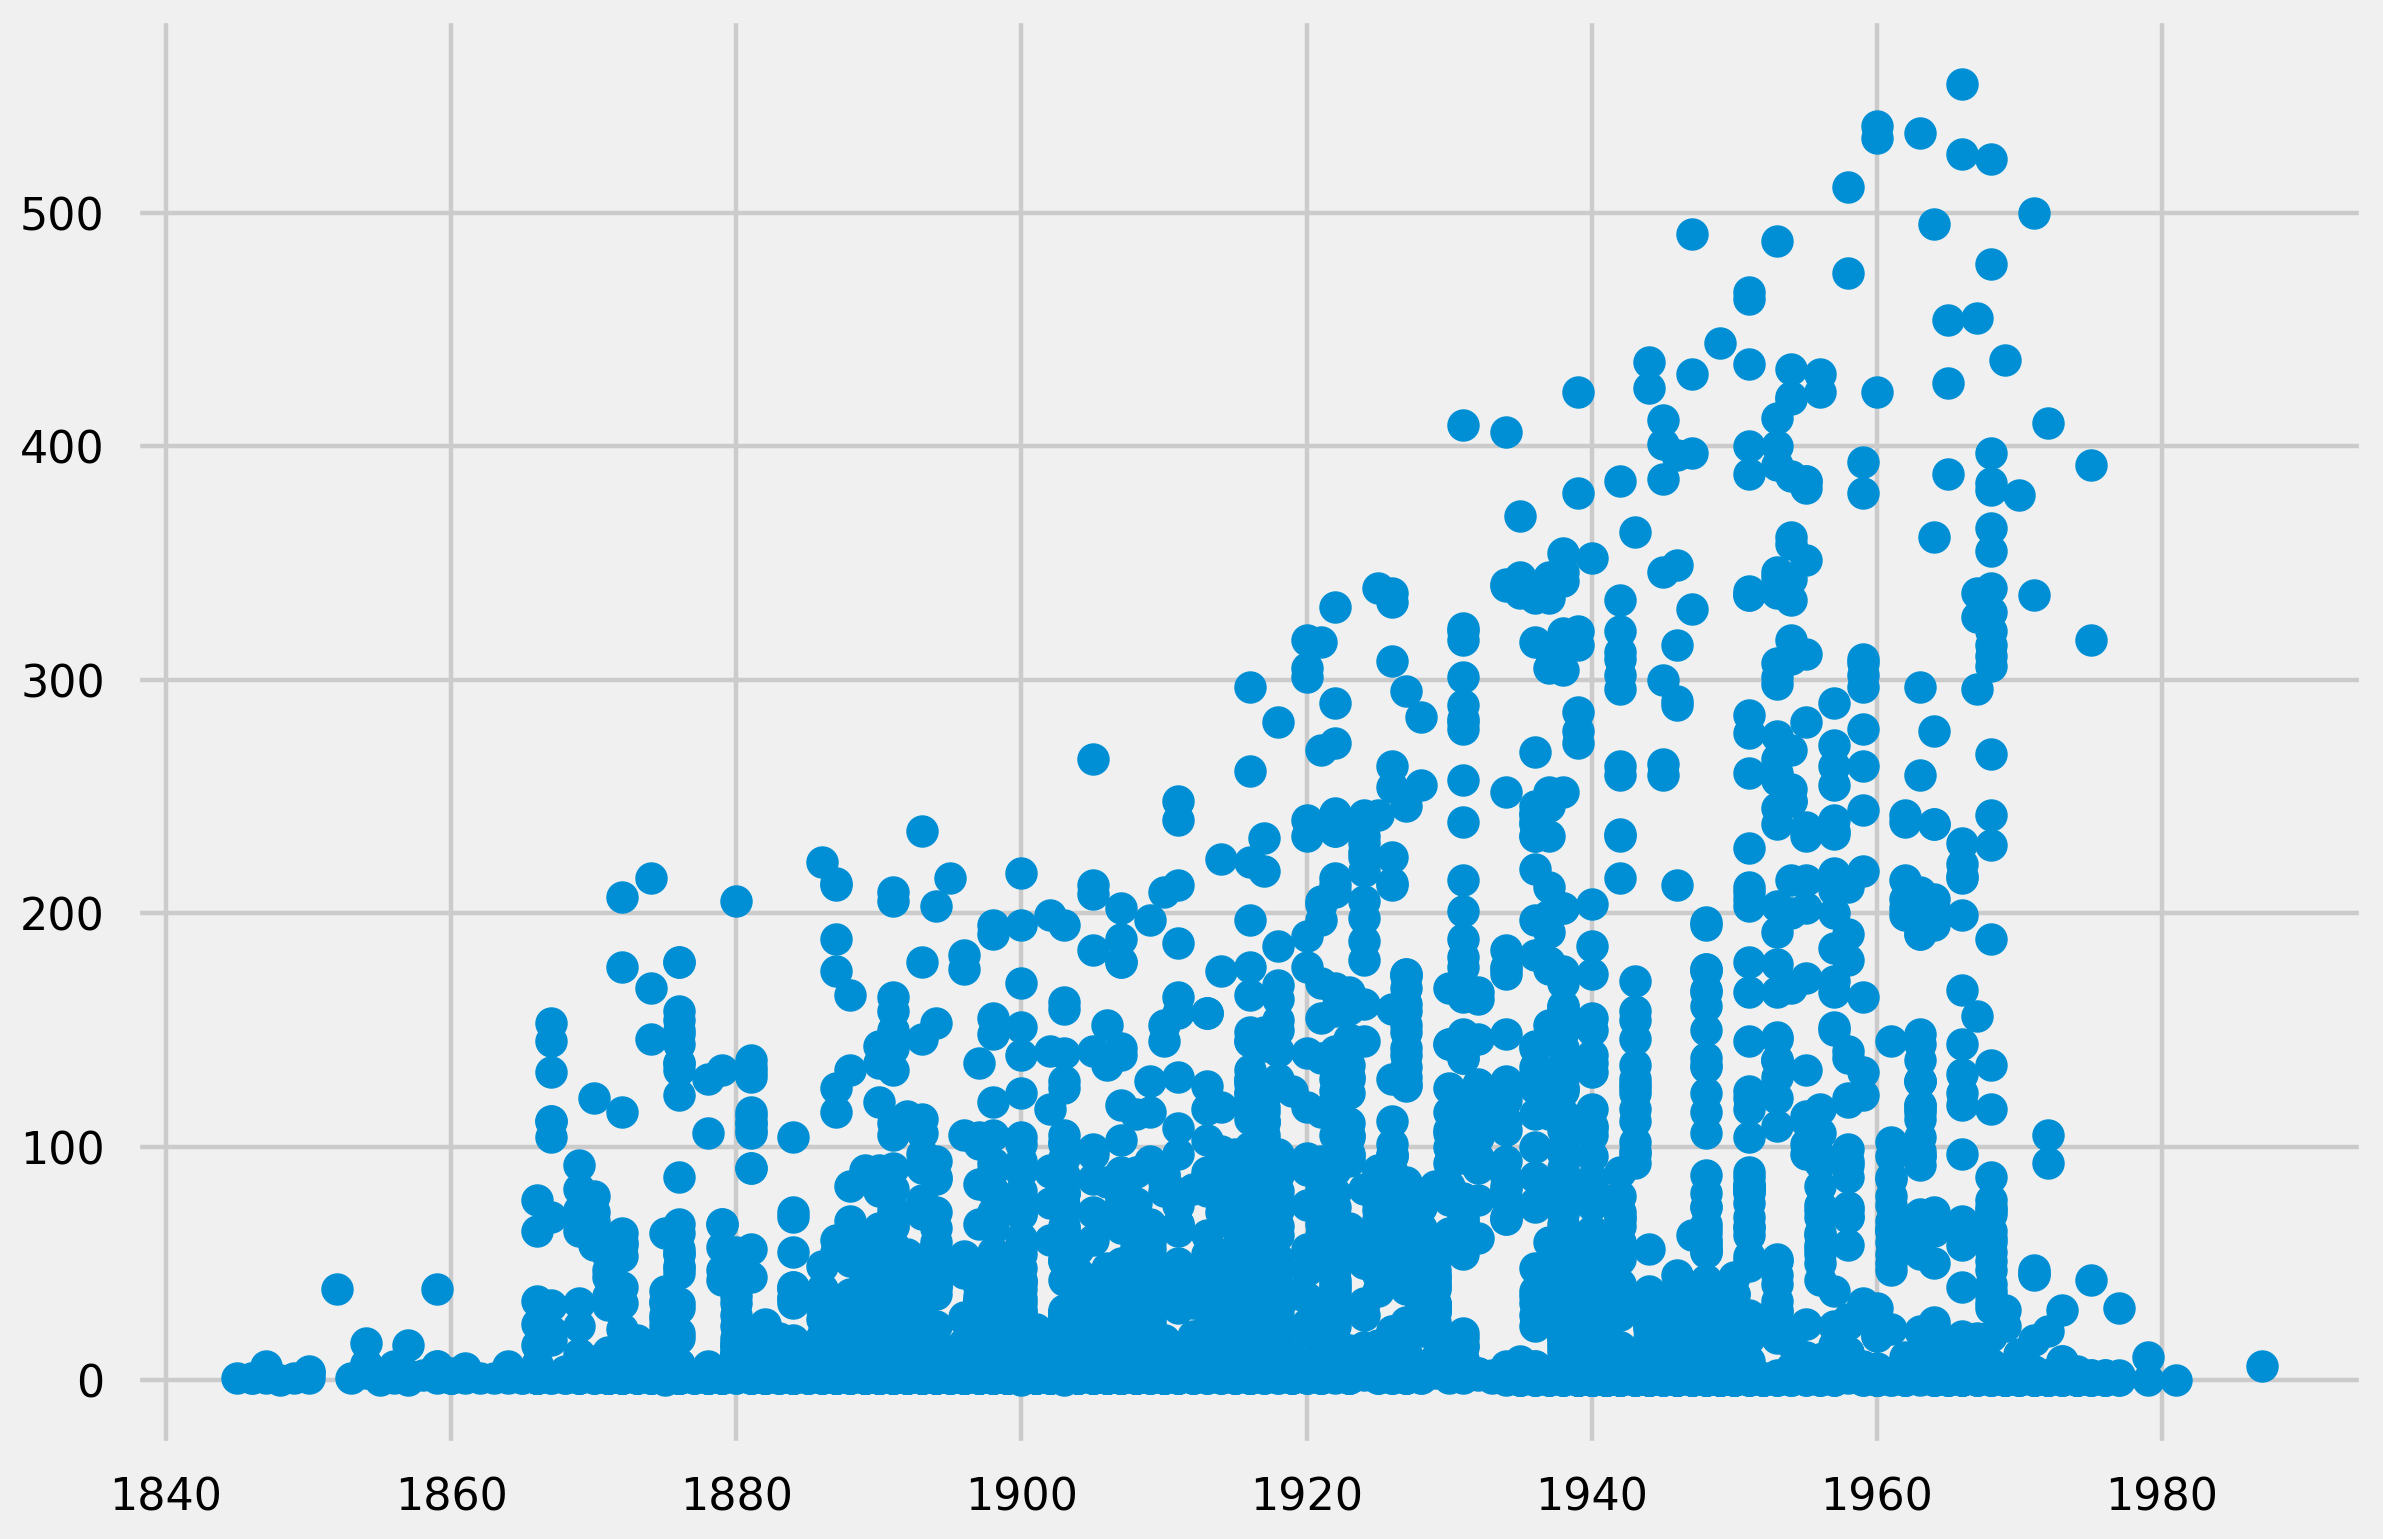

In [46]:
plt.scatter(hofers['birthYear'], hofers['votes'])

Looks like HOFers are getting more votes than they used to, but that's probably because more people vote in every HOF class. Fortunately the dataset includes a `needed` column that tells us how many votes were needed for entry.

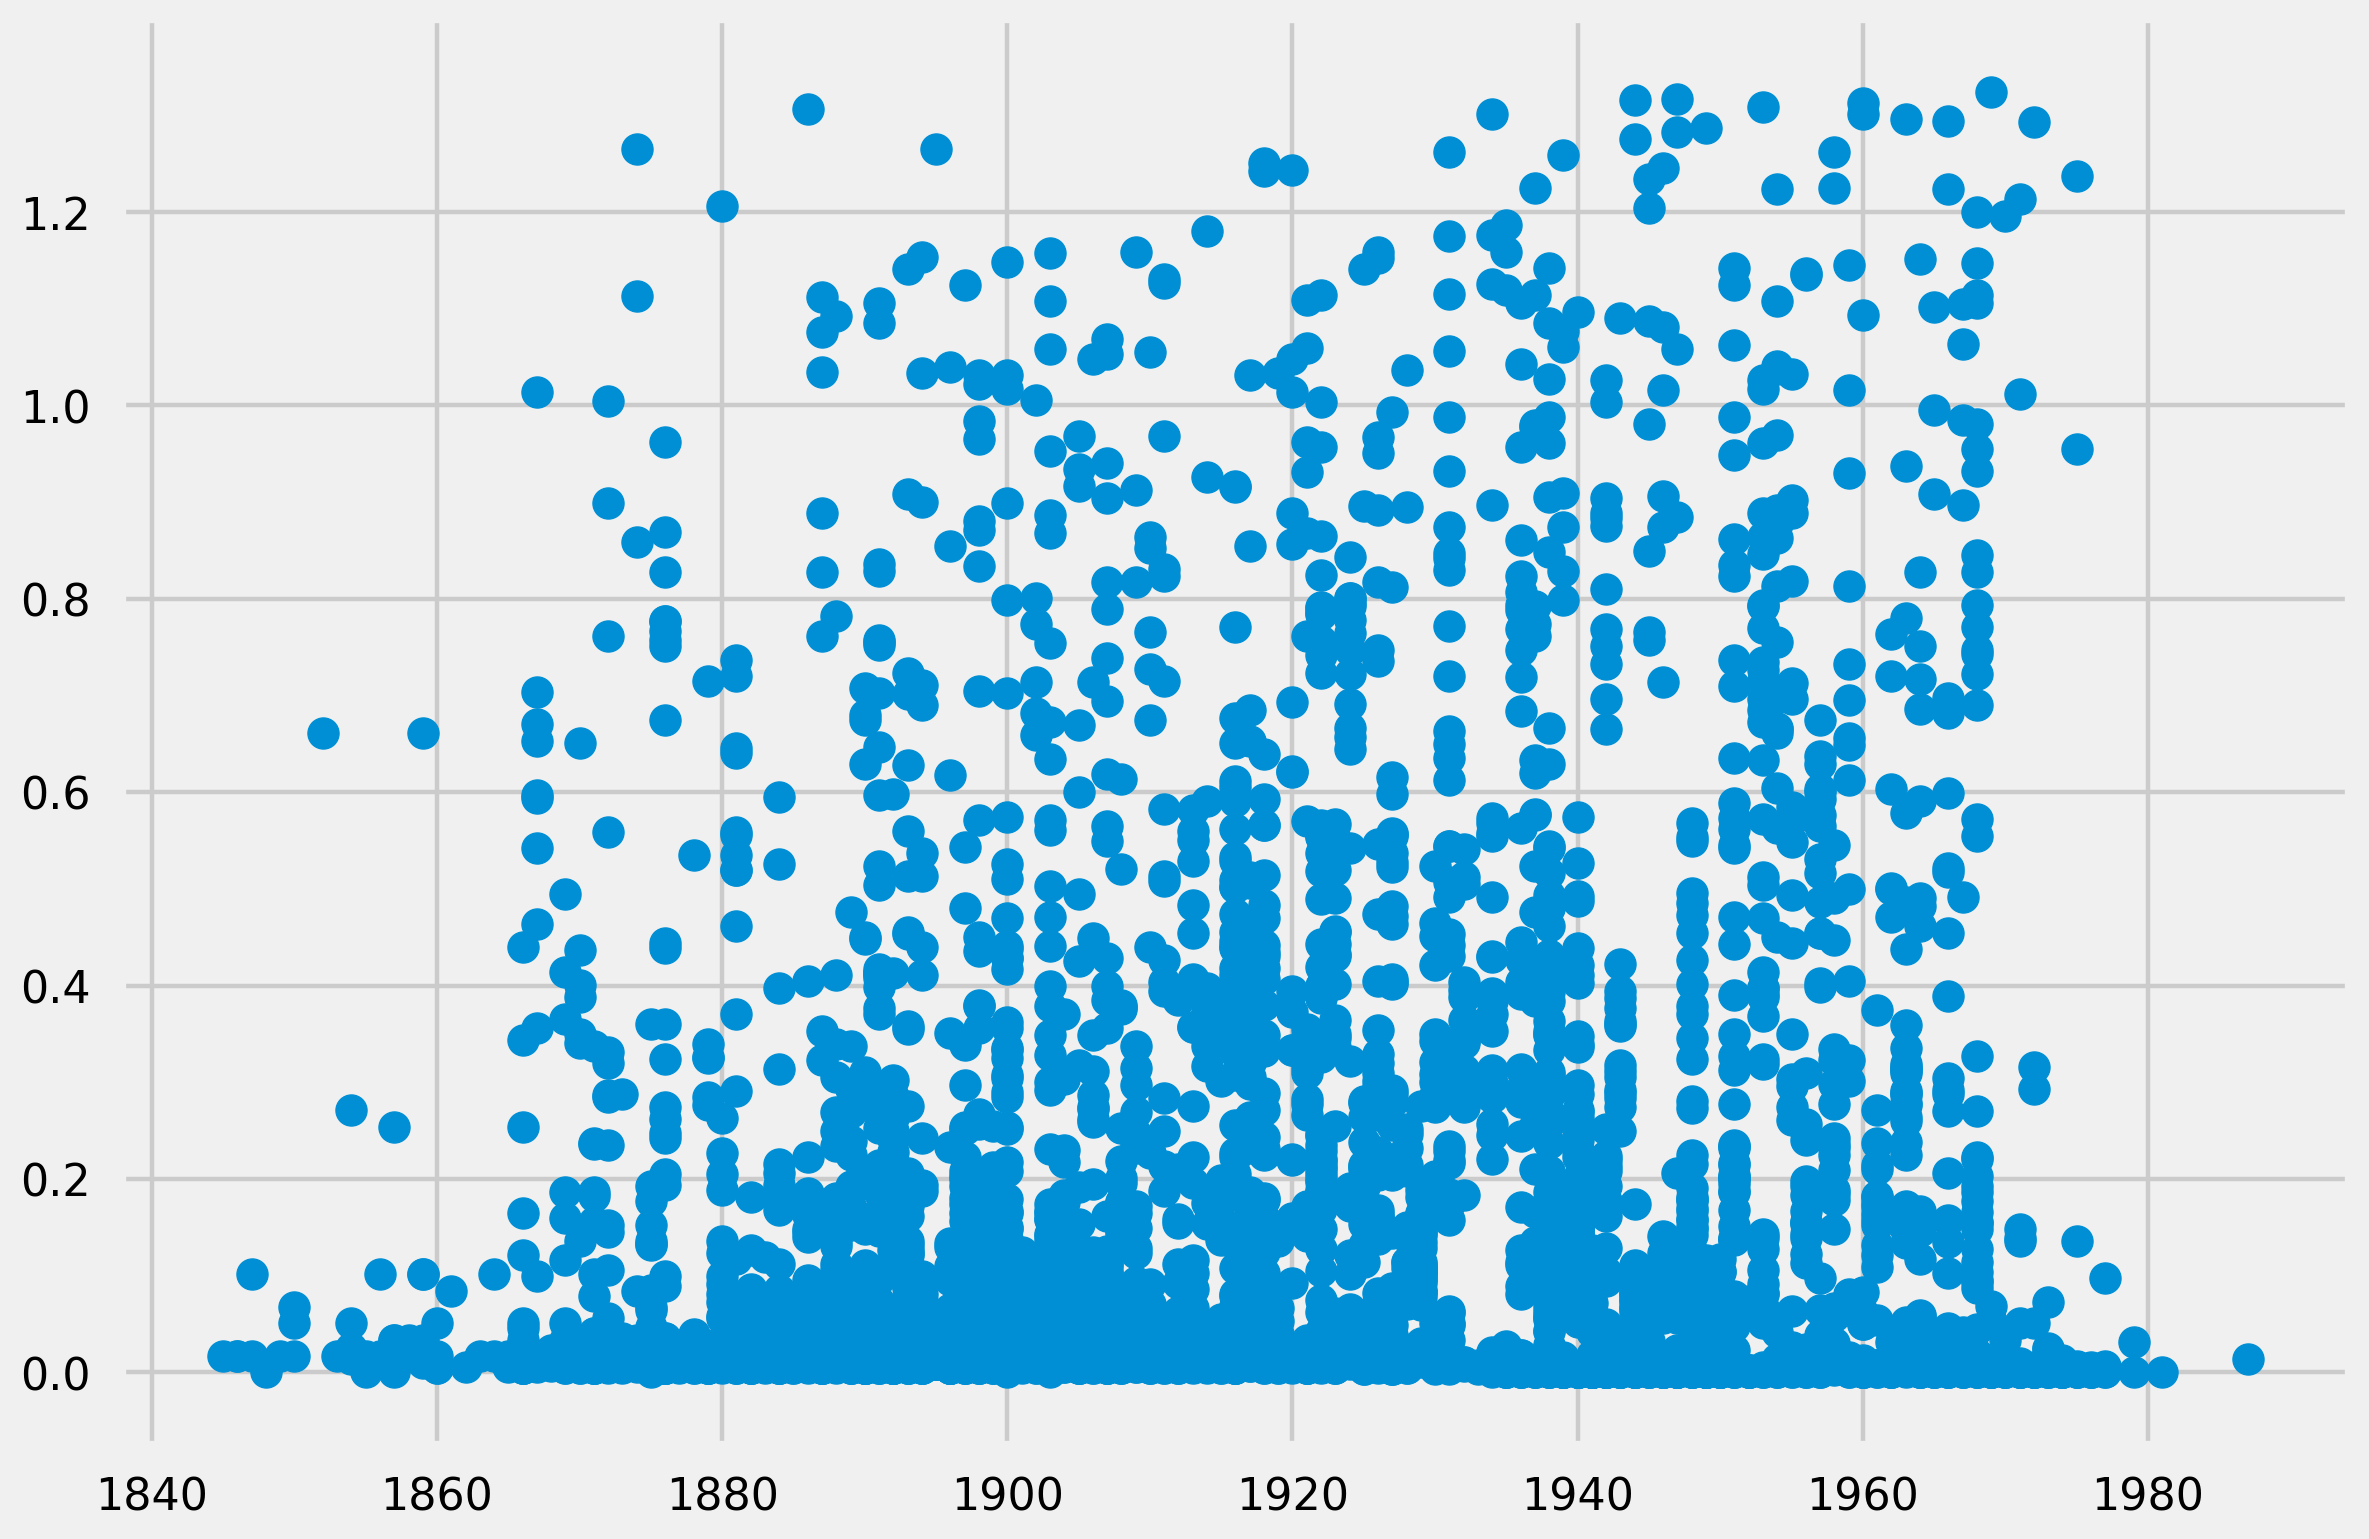

In [47]:
hofers['vote_share'] = hofers['votes'] / hofers['needed']
plt.scatter(hofers['birthYear'], hofers['vote_share'])

I want to look at Hall of Fame players by position, so I'll need to join in yet another table, the `Positions` table.

In [48]:
hofers = pd.merge(fielding, hof, on='playerID', how='inner')

In [49]:
# TODO - why did I lose some players who didn't have positions?
hofers.playerID.nunique()

1201

Hmm, we lost some players when we did this join (we used to have 1227). I'll need to go back and figure out why this is.

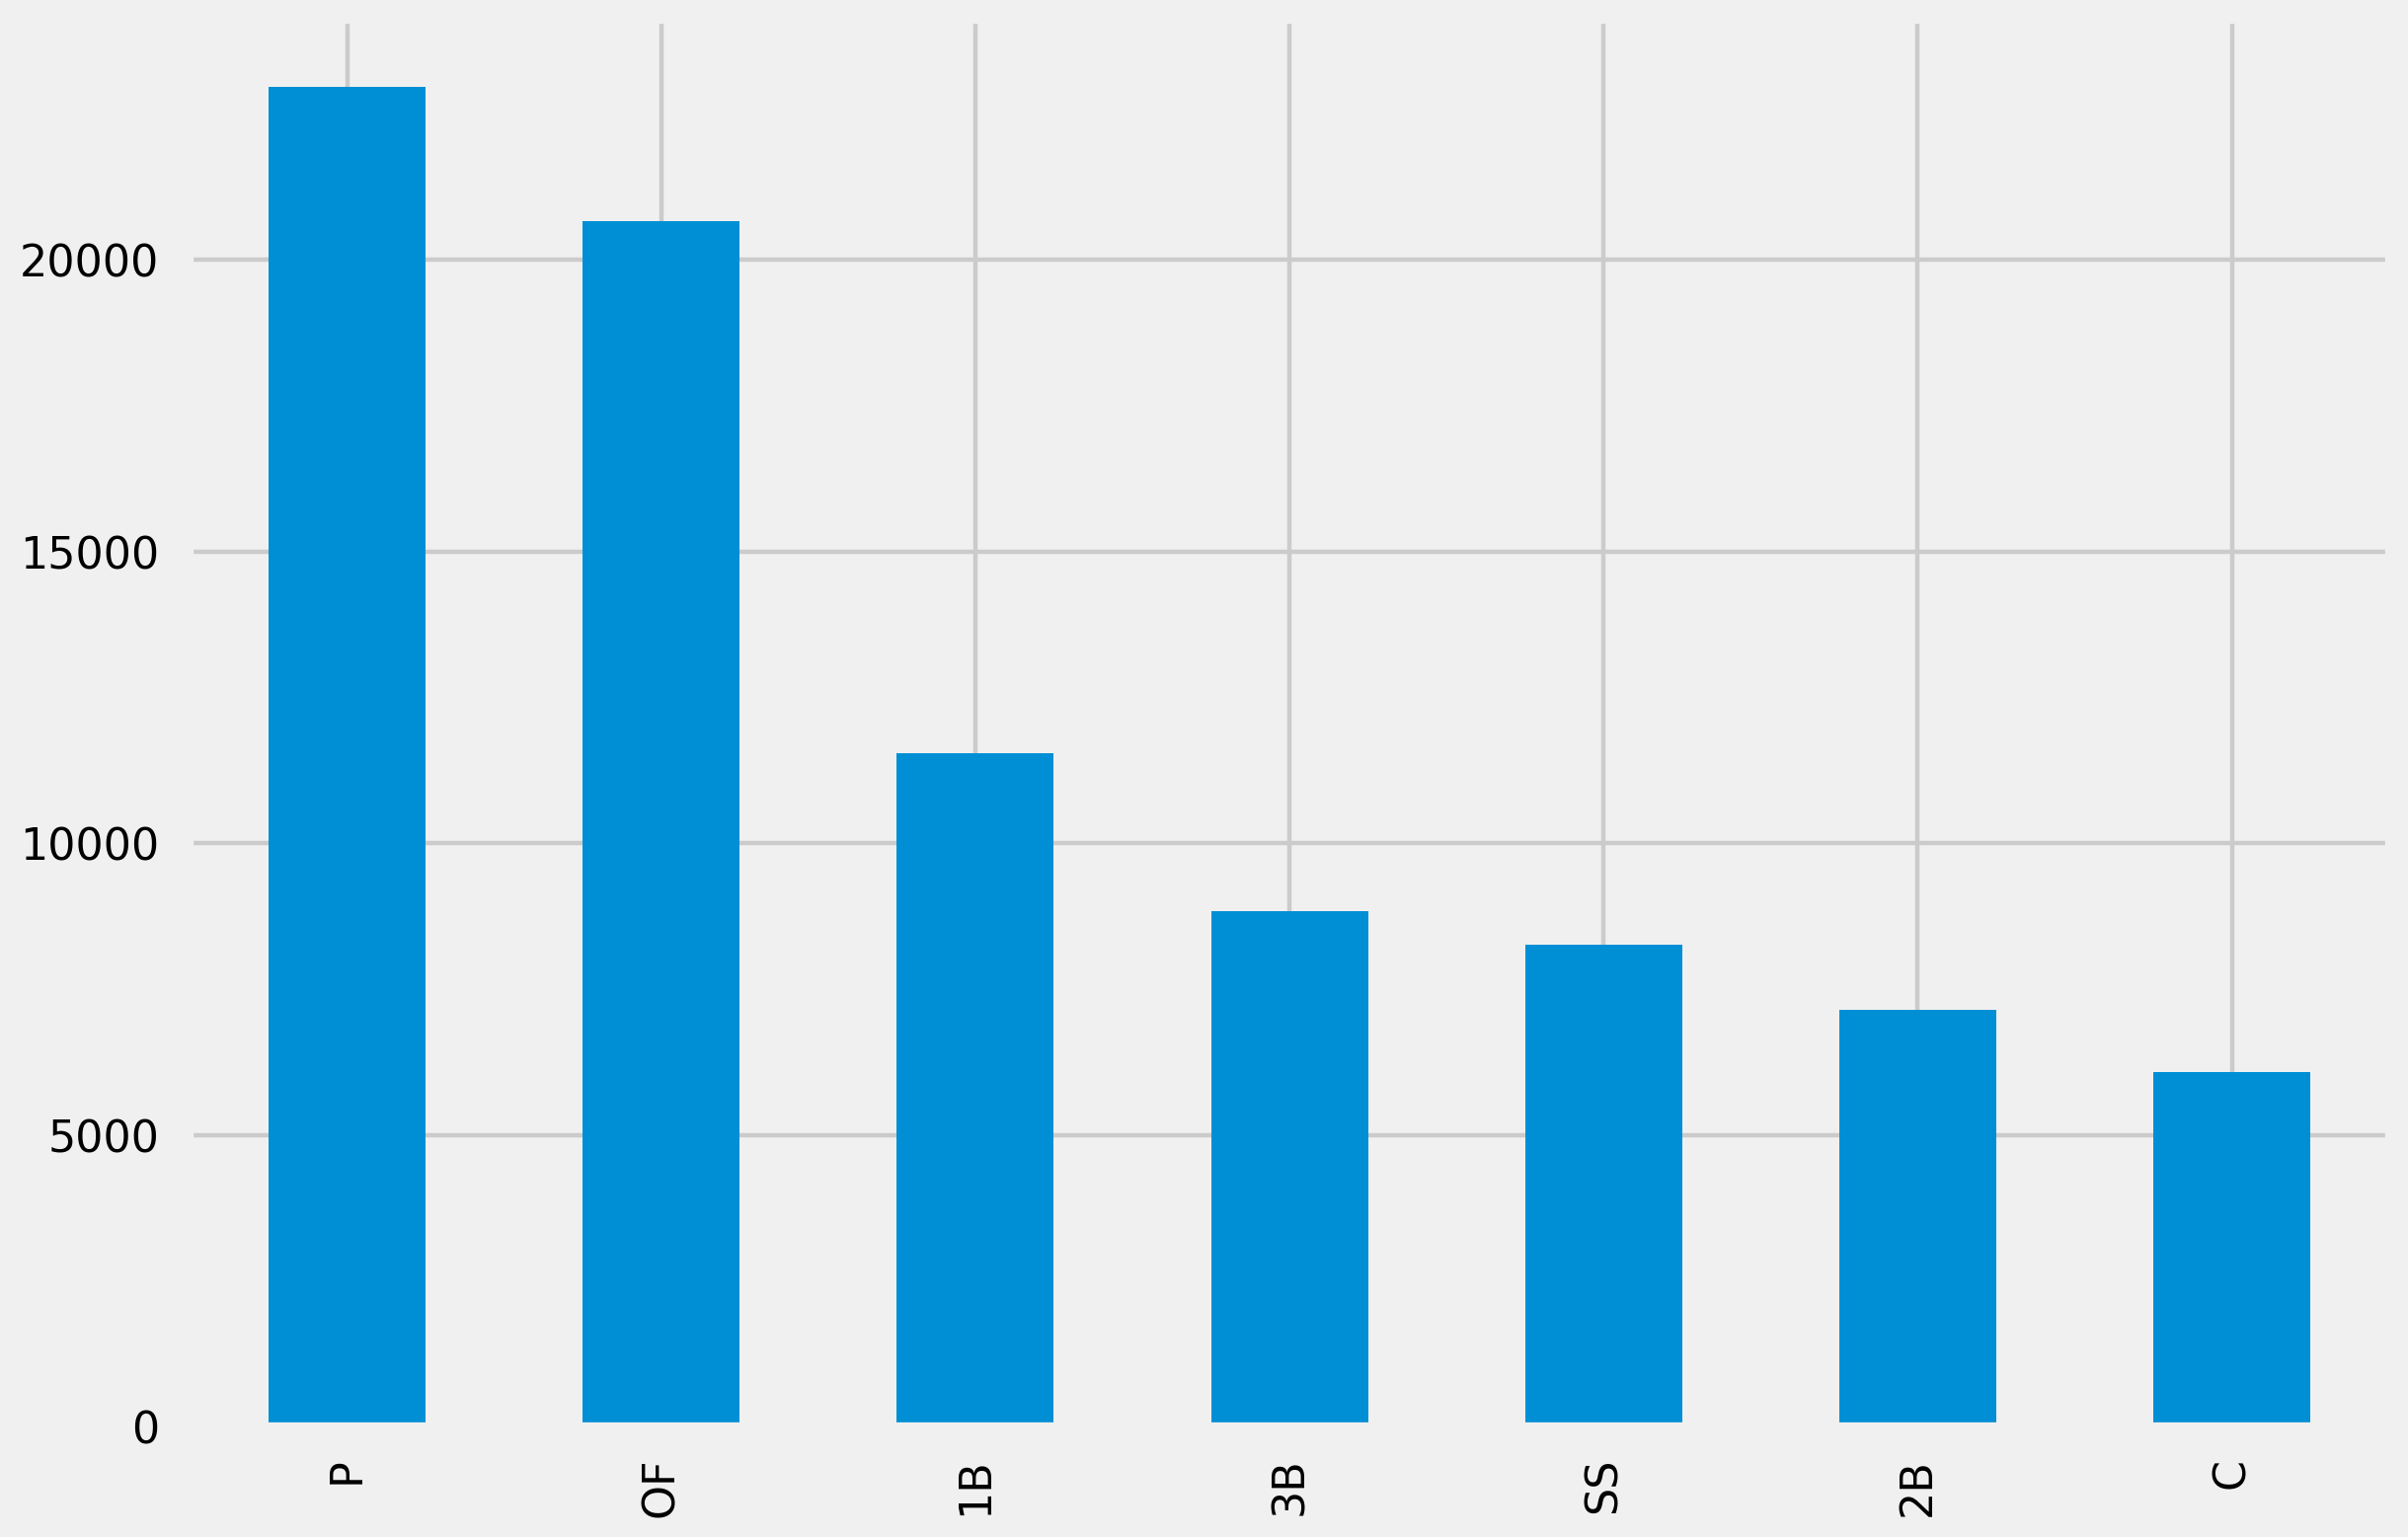

In [50]:
pd.value_counts(hofers['POS']).plot.bar()

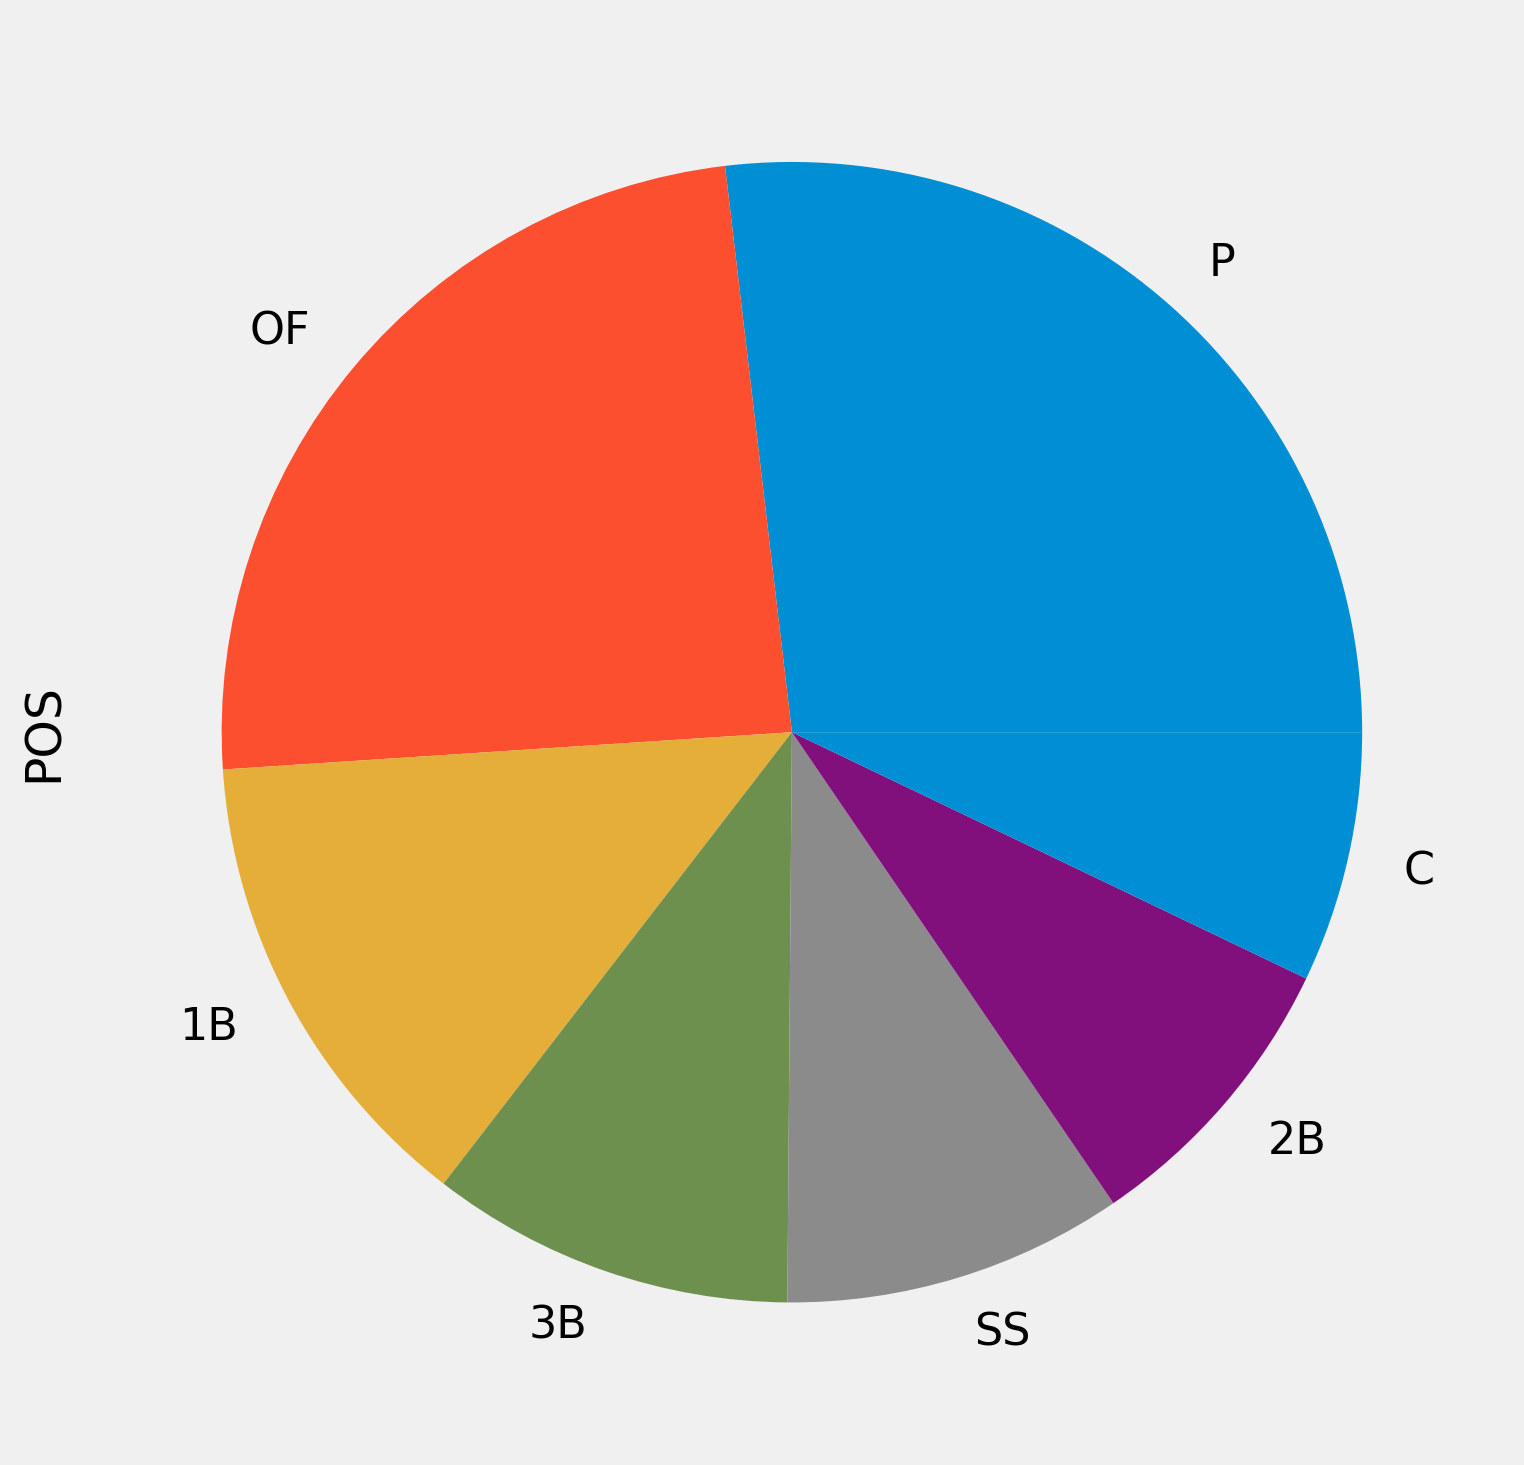

In [51]:
pd.value_counts(hofers['POS']).plot.pie()

Pitcher is the most popular position in the HOF, followed by OF. Catcher is the least popular.

## Batting

To analyze batting stats by position, we'll need to join on the fielding table (to get a player's position).

```
2.4 Fielding Table
playerID       Player ID code
yearID         Year
stint          player's stint (order of appearances within a season)
teamID         Team
lgID           League
Pos            Position
G              Games 
GS             Games Started
InnOuts        Time played in the field expressed as outs 
PO             Putouts
A              Assists
E              Errors
DP             Double Plays
PB             Passed Balls (by catchers)
WP             Wild Pitches (by catchers)
SB             Opponent Stolen Bases (by catchers)
CS             Opponents Caught Stealing (by catchers)
ZR             Zone Rating
------------------------------------------------------------------------------
2.2 Batting Table
playerID       Player ID code
yearID         Year
stint          player's stint (order of appearances within a season)
teamID         Team
lgID           League
G              Games
AB             At Bats
R              Runs
H              Hits
2B             Doubles
3B             Triples
HR             Homeruns
RBI            Runs Batted In
SB             Stolen Bases
CS             Caught Stealing
BB             Base on Balls
SO             Strikeouts
IBB            Intentional walks
HBP            Hit by pitch
SH             Sacrifice hits
SF             Sacrifice flies
GIDP           Grounded into double plays
```

In [52]:
batting.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,0,0,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,0,0,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,5,0,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,2,2,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,3,0,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0


Let's add Batting Avg (BAVG) to our dataframe.

In [53]:
batting['BAVG'] = batting['H'] / batting['AB']

In [54]:
batting.BAVG.describe()

count    89521.000000
mean         0.208322
std          0.122852
min          0.000000
25%          0.145833
50%          0.230769
75%          0.273973
max          1.000000
Name: BAVG, dtype: float64

MLB rules say "a player must have 3.1 plate appearances (PA) per team game (for a total of 502 over the current 162-game season) to qualify for the batting title." So let's restrict to only player-seasons with a minimum of 502 ABs.

In [55]:
df = batting[batting['AB'] >= 502]

In [56]:
df.BAVG.describe()

count    8864.000000
mean        0.285004
std         0.031043
min         0.188867
25%         0.263913
50%         0.283004
75%         0.303677
max         0.439703
Name: BAVG, dtype: float64

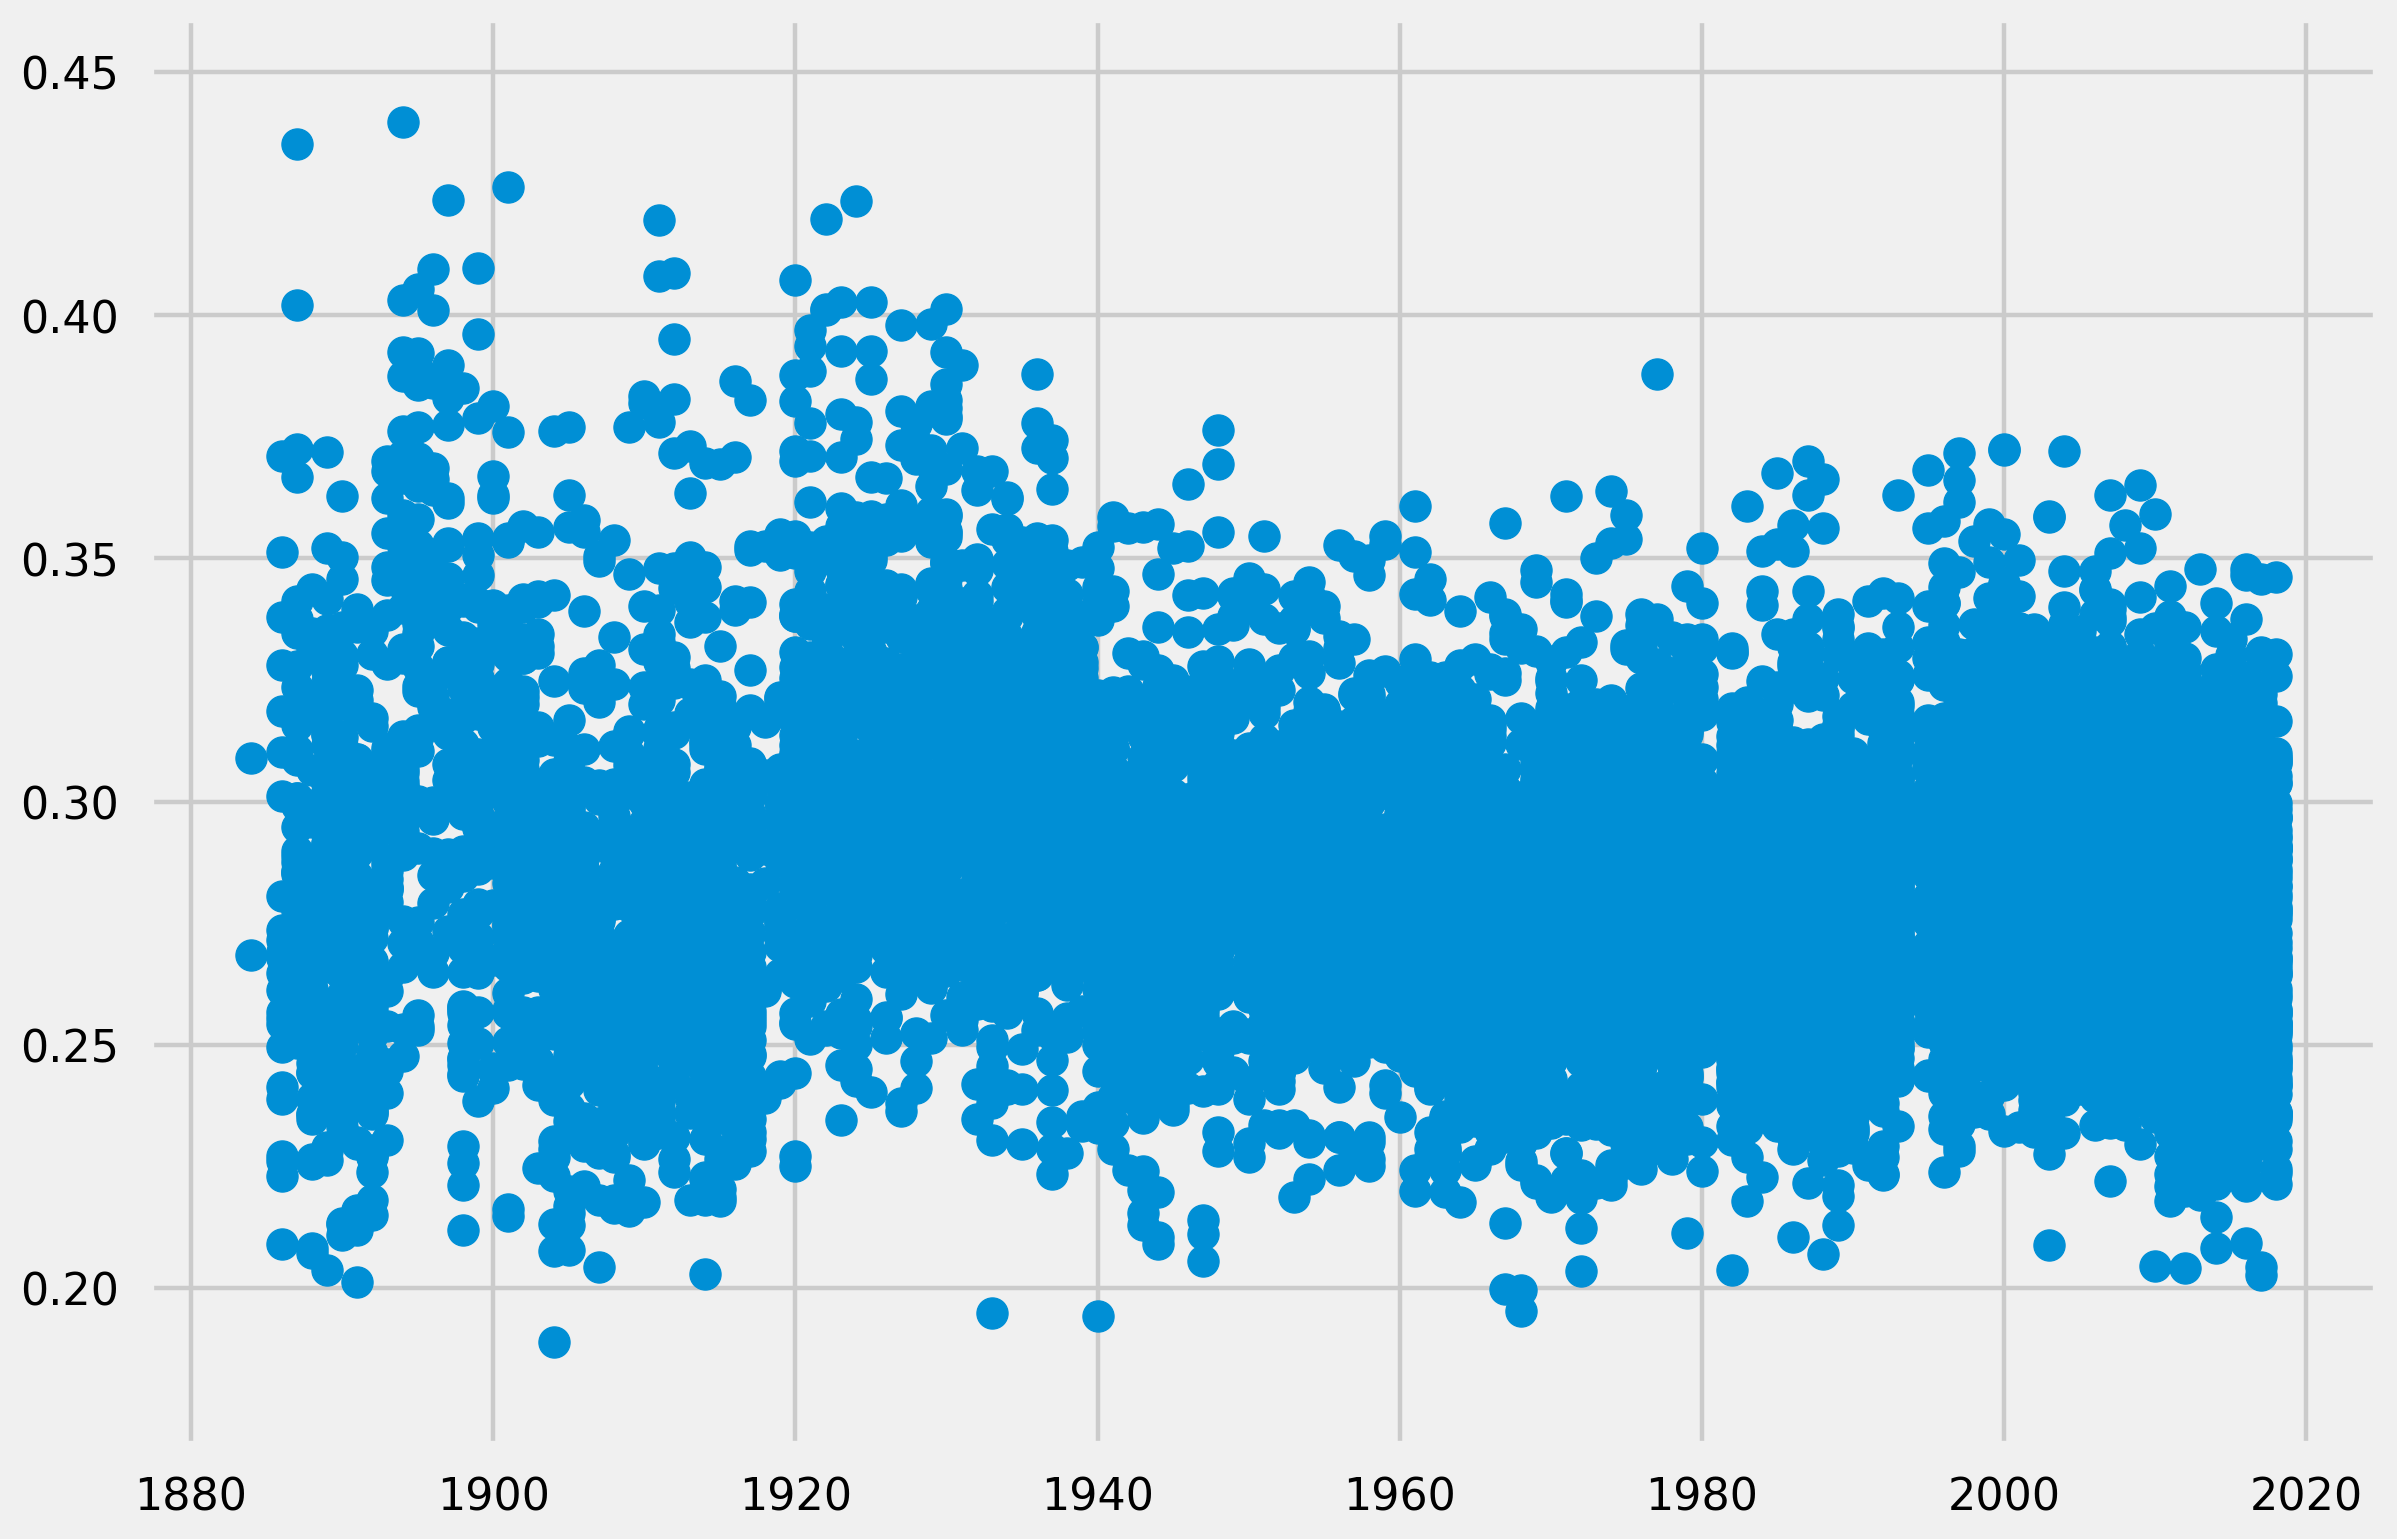

In [57]:
plt.scatter(df['yearID'], df['BAVG'])

Let's just look at the Modern Era* for now.

\* Modern Era = since I became an active fan of the game

In [58]:
df = df[df['yearID'] > 1980]

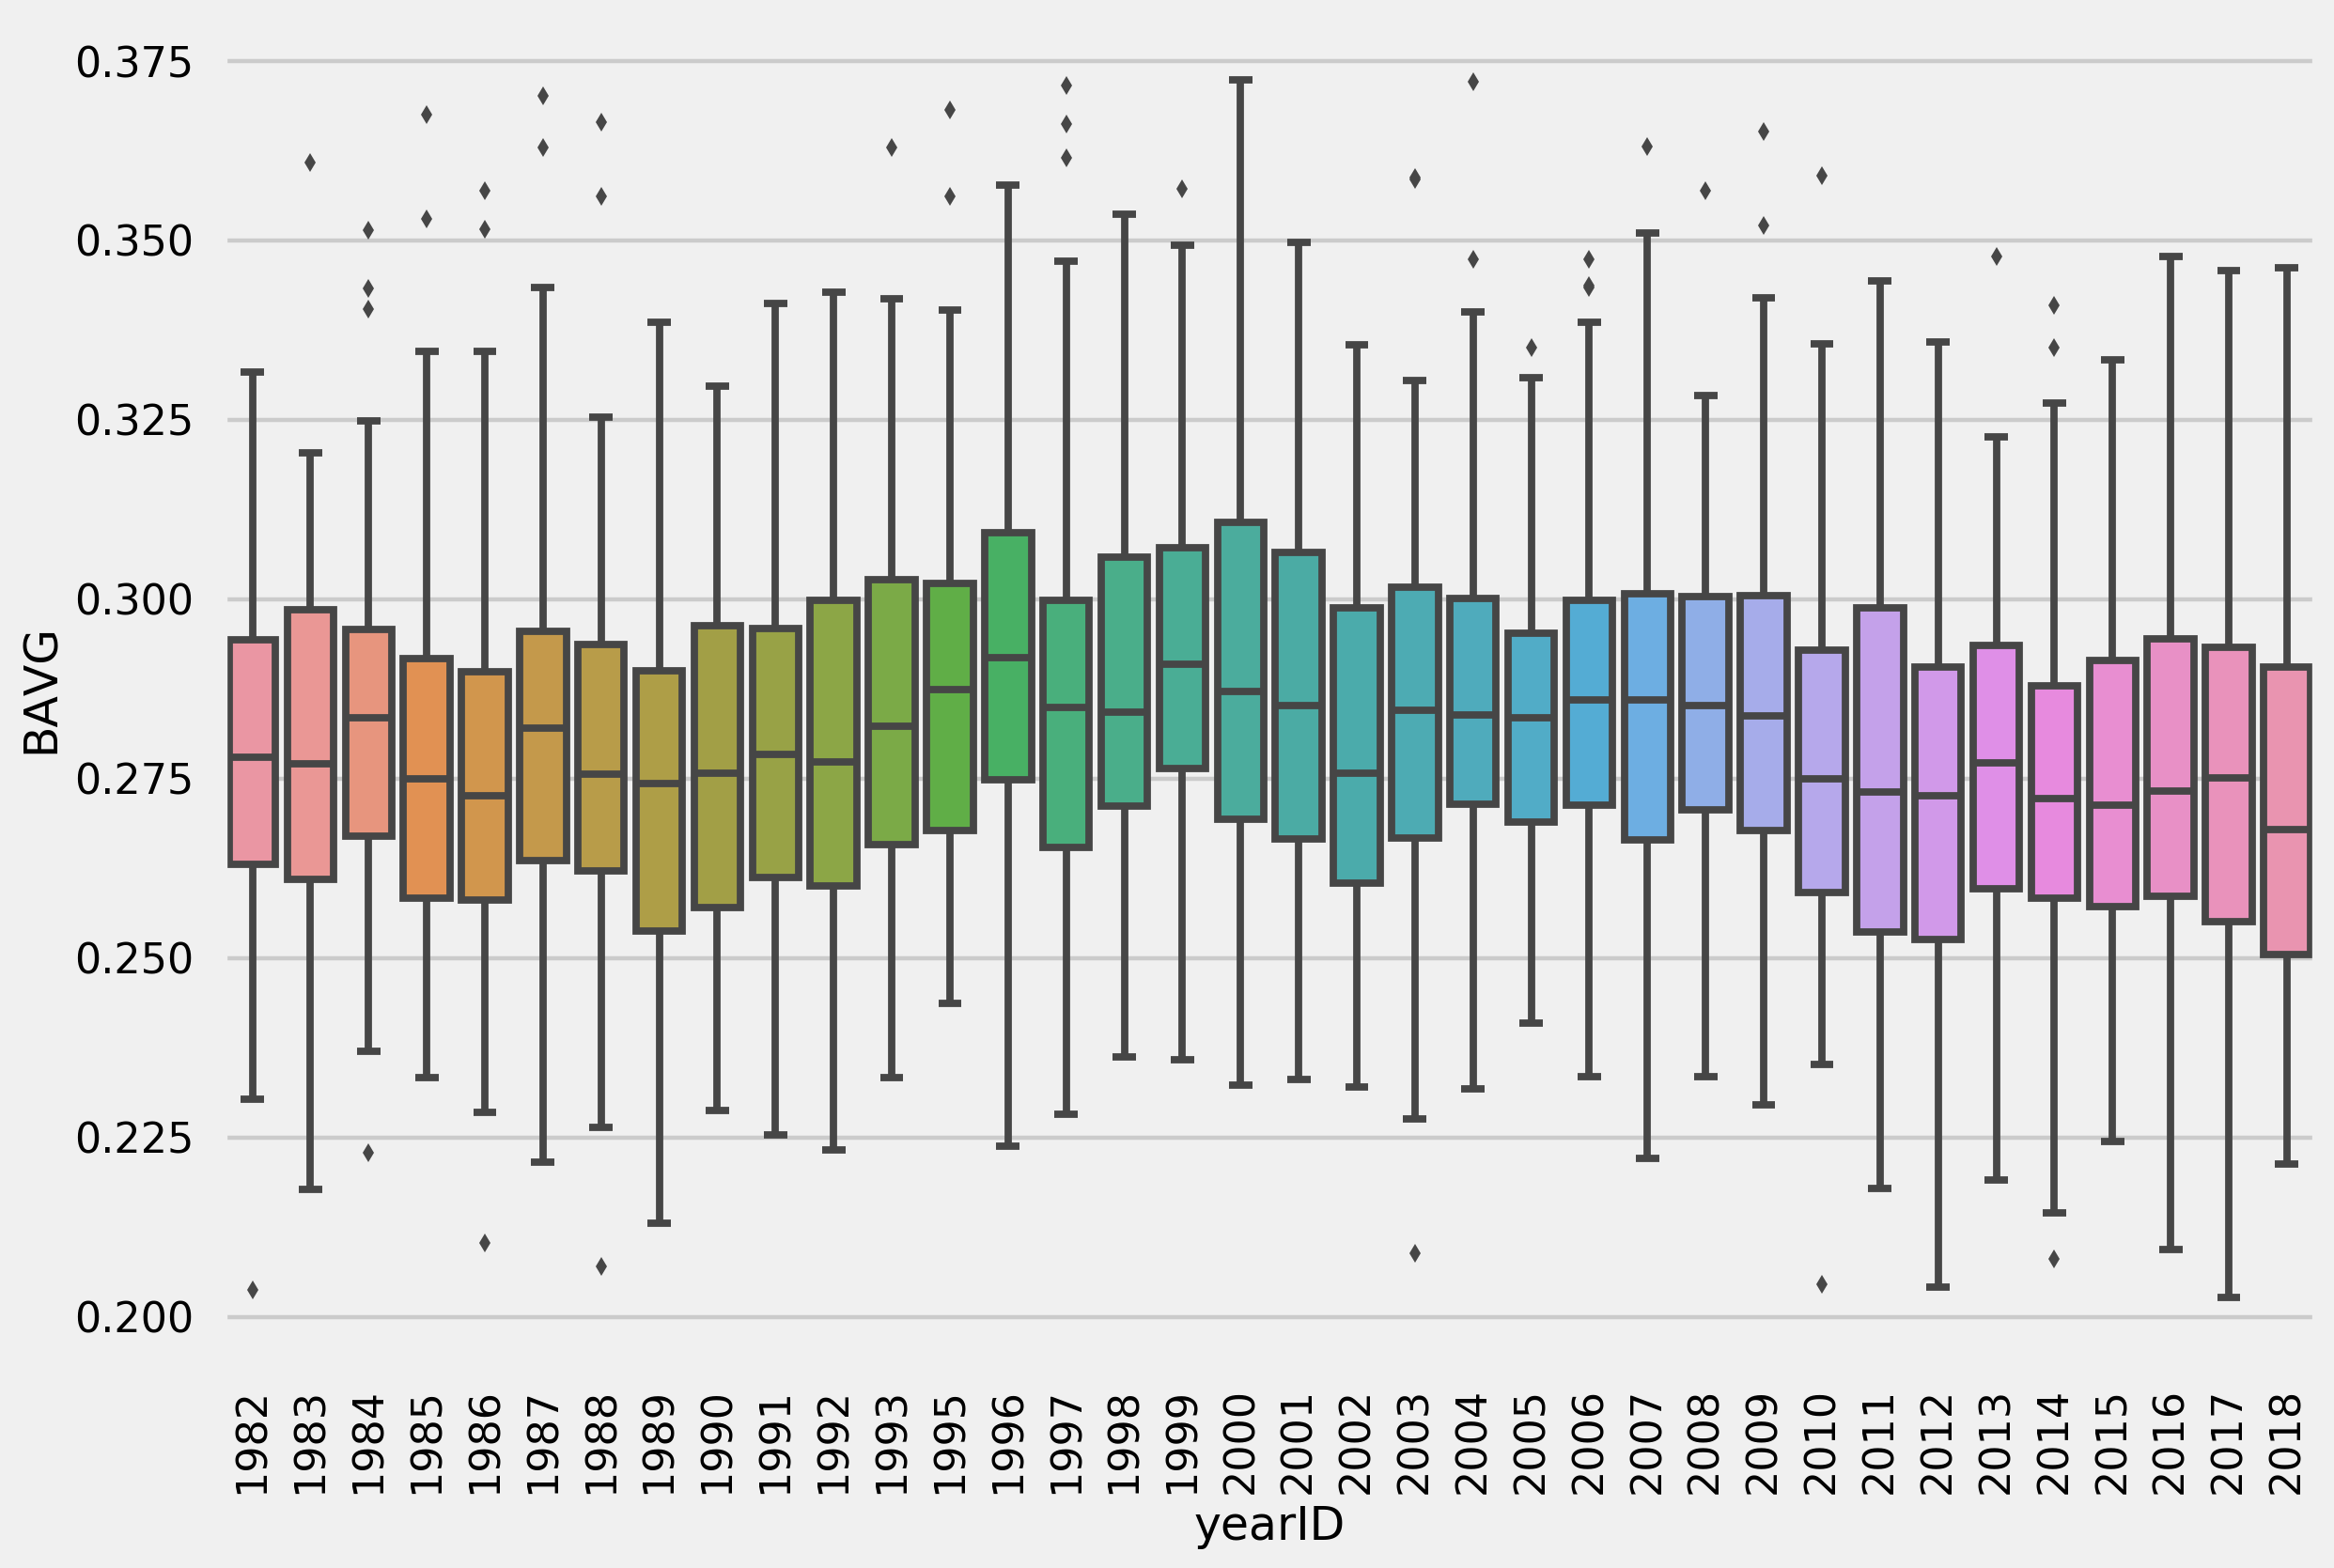

In [59]:
plt.xticks(rotation=90)
sns.boxplot(x="yearID", y="BAVG", data=df)

What were the batting averages of the players who won the batting title each year?

In [60]:
df.groupby(['yearID'], sort=False)['BAVG'].max()

yearID
1982    0.331624
1983    0.360825
1984    0.351485
1985    0.367534
1986    0.356897
1987    0.370119
1988    0.366438
1989    0.338583
1990    0.329749
1991    0.341256
1992    0.342803
1993    0.362976
1995    0.368224
1996    0.357737
1997    0.371622
1998    0.353680
1999    0.357143
2000    0.372414
2001    0.349711
2002    0.335505
2003    0.358714
2004    0.372159
2005    0.335017
2006    0.347409
2007    0.363025
2008    0.356870
2009    0.365201
2010    0.359073
2011    0.344406
2012    0.335849
2013    0.347748
2014    0.340909
2015    0.333333
2016    0.347826
2017    0.345763
2018    0.346154
Name: BAVG, dtype: float64

Who had the best batting average during this period, and who was he?

In [61]:
df.loc[df['BAVG'].idxmax()]

playerID    heltoto01
yearID           2000
stint               1
teamID            COL
lgID               NL
G                 160
AB                580
R                 138
H                 216
2B                 59
3B                  2
HR                 42
RBI               147
SB                  5
CS                  3
BB                103
SO                 61
IBB                22
HBP                 4
SH                  0
SF                 10
GIDP               12
BAVG         0.372414
Name: 79774, dtype: object

In [62]:
people[people['playerID'] == 'heltoto01']

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
7625,heltoto01,1973.0,8.0,20.0,USA,TN,Knoxville,NaN,NaN,NaN,NaN,NaN,NaN,Todd,Helton,Todd Lynn,220.0,74.0,L,L,1997-08-02,2013-09-29,heltt001,heltoto01
